In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Library**

In [ ]:
# Data Manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
%matplotlib inline

# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Normality test
from scipy.stats import shapiro
from scipy.stats import normaltest

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
!pip install category_encoders
import category_encoders as ce

# Model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import statsmodels.api as sm 

# Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# eXplainable AI
!pip install lime
from lime import lime_tabular
!pip install shap
import shap

# Metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Save and Load model
import pickle, os
os.makedirs('file_model', exist_ok=True)

# Ignore warning
import warnings
warnings.filterwarnings("ignore")

# **Problem Statement**

Disini kita memposisikan diri sebagai Consultant. Client kita adalah spekulan yang bisnisnya mengambil untung dari membeli dan menjual mobil di [Exchange and Mart](https://www.exchangeandmart.co.uk/). Problem yang dia hadapi adalah dia tidak tahu diharga berapa dia seharusnya membeli mobil, dan diharga berapa dia bisa menjual mobil dengan keuntungan yang maksimal.

Tujuan kita adalah memberikan prediksi harga mobil berdasarkan harga yang ada di Exchange and Mart dan memberikan hasil analisa data yang kita lakukan.

## Problem Statement For Machine Learning

-	Memprediksi harga mobil bekas, agar pelaku bisnis dan calon pembeli dapat meminimalkan overpricing maupun underpricing ketika melakukan jual beli di Exchange and Mart (regresi).

## Problem Statement For Analytics

-	Mencari brand mobil mana yang mengalami depresiasi value terbesar dan terkecil. Pelaku bisnis jual beli mobil bekas biasanya akan menjual mobil yang paling laris, mobil yang paling laris salah satu cirinya ditandai dengan harga mobil yang relatif stabil (depresiasinya rendah).

# **Data Understanding**

## Deskripsi Data



Sumber data: [Kaggle](https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes?select=audi.csv) 

Data ini merupakan data daftar mobil bekas hasil dari scraping web **Exchange and Mart**. Exchange and Mart merupakan perusahaan jual beli otomotif yang beroperasi secara online. Tidak hanya mobil saja, perusahaan ini juga melakukan jual beli motor. Namun di dataset kali ini, fokus datanya terbatas pada segmen mobil saja dengan 9 produsen mobil (Audi, BMW, Ford, Hyundai, Mercedes, Skoda, Toyota, Vauxhall, VW).

## Data

### Unit Analysis

In [ ]:
df_audi = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT PURWADHIKA/DATA/audi.csv')
df_bmw = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT PURWADHIKA/DATA/bmw.csv')
df_ford = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT PURWADHIKA/DATA/ford.csv')
df_hyundai = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT PURWADHIKA/DATA/hyundi.csv')
df_merc = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT PURWADHIKA/DATA/merc.csv')
df_skoda = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT PURWADHIKA/DATA/skoda.csv')
df_toyota = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT PURWADHIKA/DATA/toyota.csv')
df_vauxhall = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT PURWADHIKA/DATA/vauxhall.csv')
df_vw = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT PURWADHIKA/DATA/vw.csv')
df_c_class = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT PURWADHIKA/DATA/cclass.csv')
df_focus = pd.read_csv('/content/drive/MyDrive/FINAL PROJECT PURWADHIKA/DATA/focus.csv')

In [ ]:
# Perbaiki nama kolom tax di data hyundai
df_hyundai.rename({'tax(£)': 'tax'}, axis=1, inplace=True)

**Menggabungkan Data**

In [ ]:
# tambahkan kolom manufacturer
df_audi['manufacturer'] = 'Audi'
df_bmw['manufacturer'] = 'BMW'
df_ford['manufacturer'] = 'Ford'
df_focus['manufacturer'] = 'Ford'
df_hyundai['manufacturer'] = 'Hyundai'
df_merc['manufacturer'] = 'Mercedes'
df_c_class['manufacturer'] = 'Mercedes'
df_skoda['manufacturer'] = 'Skoda'
df_toyota['manufacturer'] = 'Toyota'
df_vauxhall['manufacturer'] = 'Vauxhall'
df_vw['manufacturer'] = 'VW'


# concat keseluruhan file
df = pd.concat([df_audi,df_bmw,df_c_class,df_ford,df_focus,df_hyundai,df_merc,df_skoda,df_toyota,df_vauxhall,df_vw])
df.reset_index(drop=True, inplace=True)

# rename beberapa nama kolom ('mileage' menjadi 'totalMileage')('mpg' menjadi 'fuelConsumption(mpg)')
df.rename(columns={'mileage':'totalMileage', 'mpg': 'fuelConsump(mpg)'}, inplace=True)

### Feature Extraction

**Emisi CO2**

Kita buat fitur baru untuk menghitung emisi yang dihasilkan oleh mobil. Rumus perhitungan emisi CO2 kita dapatkan dari sumber berikut : 
- https://youtu.be/D3pbB0Hex1E
- https://youtu.be/lM3tQumH1ys

In [ ]:
# untuk setiap galon yang dihabiskan akan menghasilkan 18 pounds CO2
df['co2Pounds/Mile'] = 18 / df['fuelConsump(mpg)']
df['totalCO2(Pounds)'] = df['totalMileage'] * df['co2Pounds/Mile']

# reorder kolom
columns_order = ['manufacturer', 'model', 'year', 'totalMileage',
                'transmission', 'fuelType', 'fuelConsump(mpg)','tax', 'engineSize', 'totalCO2(Pounds)',
                 'co2Pounds/Mile', 'price']
df = df[columns_order]

<b>manufacturer</b> : perusahaan pembuat mobil

<b>model</b> : Kategori model mobil.

<b>year</b> : Tahun registrasi mobil didaftarkan secara resmi di UK (bukan tahun mobil dibuat). Bisa saja mobil tertentu sudah diproduksi setahun sebelum diregistrasikan di UK.

<b>totalMileage</b> : Keseluruhan jarak tempuh mobil.

<b>transmission</b> : Tipe gearbox.

<b>fuelType</b> : Tipe bahan bakar yang digunakan.

<b>fuelConsump(Mpg)</b> : Mile per galon.

<b>tax</b> : Pajak mobil.

<b>engineSize</b> : besar mesin dalam Liter (kalikan 100 untuk merubahnya dalam bentuk CC). 

<b>totalCO2(Pounds)</b> : total keseluruhan co2 yang dihasilkan oleh mobil

<b>co2Pounds/Mile</b> : besar co2 yang dihasilkan mobil per milesnya (dalam satuan Pounds)

<b>price</b> : Harga yang ditawarkan (bukan diharga berapa mobil terjual) dalam bentuk £ (Poundsterling). 

In [ ]:
df .head()

manufacturer model  year  ...  totalCO2(Pounds) co2Pounds/Mile  price
0         Audi    A1  2017  ...       5112.454874       0.324910  12500
1         Audi    A6  2016  ...      10150.373832       0.280374  16500
2         Audi    A1  2016  ...       9729.747292       0.324910  11000
3         Audi    A4  2017  ...       6941.099554       0.267459  16800
4         Audi    A3  2019  ...        725.080645       0.362903  17300

[5 rows x 12 columns]

### Attributes

**Data Type**

In [ ]:
#mengetahui tipe data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108540 entries, 0 to 108539
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   manufacturer      108540 non-null  object 
 1   model             108540 non-null  object 
 2   year              108540 non-null  int64  
 3   totalMileage      108540 non-null  int64  
 4   transmission      108540 non-null  object 
 5   fuelType          108540 non-null  object 
 6   fuelConsump(mpg)  99187 non-null   float64
 7   tax               99187 non-null   float64
 8   engineSize        108540 non-null  float64
 9   totalCO2(Pounds)  99187 non-null   float64
 10  co2Pounds/Mile    99187 non-null   float64
 11  price             108540 non-null  int64  
dtypes: float64(5), int64(3), object(4)
memory usage: 9.9+ MB


**Atributes Description**

In [ ]:
#describe untuk data numerik
df.describe()

year   totalMileage  ...  co2Pounds/Mile          price
count  108540.000000  108540.000000  ...    99187.000000  108540.000000
mean     2017.098028   23025.928469  ...        0.348043   16890.124046
std         2.130057   21176.423684  ...        0.260766    9756.266820
min      1970.000000       1.000000  ...        0.038233     450.000000
25%      2016.000000    7491.750000  ...        0.286624   10229.500000
50%      2017.000000   17265.000000  ...        0.331492   14698.000000
75%      2019.000000   32236.000000  ...        0.382166   20940.000000
max      2060.000000  323000.000000  ...       60.000000  159999.000000

[8 rows x 8 columns]

Dari hasil describe data numerik diatas, pada kolom year kita mendapati value maksimalnya adalah 2060, sedangkan data ini discraping pada tahun 2020, dimana seharusnya 2020 adalah tahun maksimalnya. Dengan demikian, kita akan drop baris yang memiliki value tersebut. Ada kemungkinan pengguna tersebut salah ketik, dia bermaksud menulis 2006, namun typo dan malah menulis 2060.

In [ ]:
# kita akan drop data ini nantinya
df[df['year']== 2060]

manufacturer    model  year  ...  totalCO2(Pounds) co2Pounds/Mile price
43074         Ford   Fiesta  2060  ...      23049.672897       0.420561  6495

[1 rows x 12 columns]

In [ ]:
#describe untuk data kategorik (string)
df.describe(include='object')

manufacturer   model transmission fuelType
count        108540  108540       108540   108540
unique            9     195            4        5
top            Ford   Focus       Manual   Petrol
freq          23419   10042        61308    59875

### Numeric features, Categoric features, Target

In [ ]:
# variabel numeric
numeric_var = ['totalMileage', 'fuelConsump(mpg)', 'tax', 
               'engineSize', 'totalCO2(Pounds)', 'co2Pounds/Mile']

# variabel categoric
categoric_var = ['manufacturer', 'model', 'year','transmission', 'fuelType']

# target
target = df['price']

# **Exploratory Data Analysis (EDA)**

## Data Distribution

### Histogram

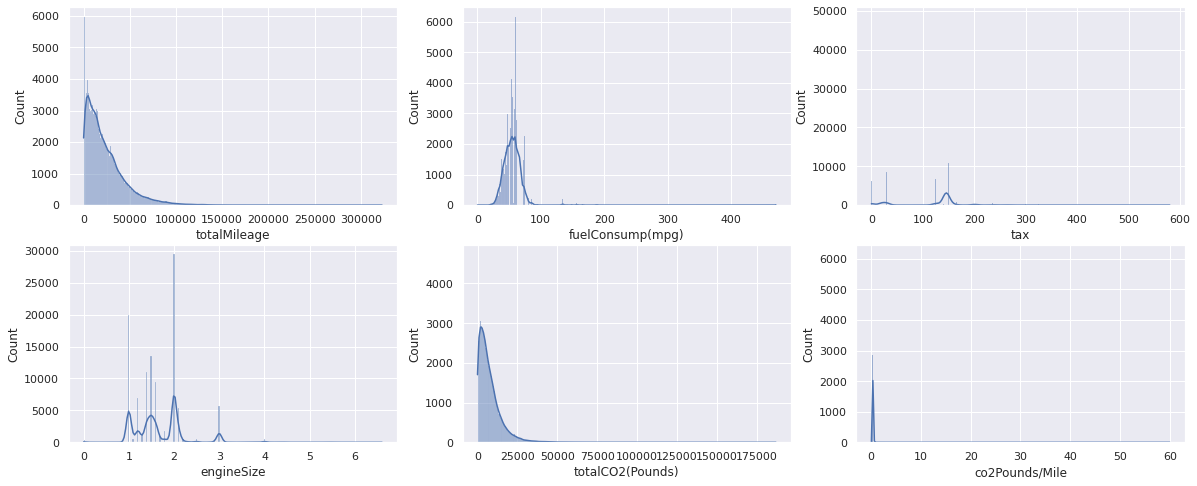

In [ ]:
plt.figure(figsize=(20,8))
for i in enumerate(numeric_var):
  plt.subplot(2,3,i[0]+1)
  sns.histplot(df[i[1]], kde=True);

### Normality Test

Karena fitur numeric data ini terdapat missing value, dan normality test bekerja dengan baik jika datanya tidak ada missing value, maka terlebih dahulu kita akan impute missing valuenya dengan knn imputer.

Untuk menghindari data leakage, kita akan menggunakan dataframe copyan dari dataframe asli.

In [ ]:
# buat copyan dari df asli
df_copy = df.copy()

# siapkan KNNimputer
knn_imputer = KNNImputer()

# siapkan ColumnTransformers
knn_transform = ColumnTransformer([
                                 ('knn_imputer', knn_imputer,['fuelConsump(mpg)','tax','totalCO2(Pounds)','co2Pounds/Mile'])
],remainder='passthrough')

# nama kolom 
df_copy_col_name = knn_transform.transformers[0][2] + ['manufacturer', 'model','year',
                                                                  'totalMileage','transmission','fuelType','engineSize','price']
# fit dan transform, lalu rubah ke format dataframe
df_copy = pd.DataFrame(knn_transform.fit_transform(df_copy), columns=df_copy_col_name)
df_copy

fuelConsump(mpg)  tax totalCO2(Pounds)  ... fuelType engineSize  price
0                  55.4  150          5112.45  ...   Petrol        1.4  12500
1                  64.2   20          10150.4  ...   Diesel          2  16500
2                  55.4   30          9729.75  ...   Petrol        1.4  11000
3                  67.3  145           6941.1  ...   Diesel          2  16800
4                  49.6  145          725.081  ...   Petrol          1  17300
...                 ...  ...              ...  ...      ...        ...    ...
108535             58.9  125          22614.6  ...   Diesel          2   5990
108536             46.3  145          34251.3  ...   Petrol        1.2   1799
108537               42  200            30000  ...   Petrol        1.4   1590
108538             46.3  150          32152.7  ...   Petrol        1.2   1250
108539             46.3  145          28768.9  ...   Petrol        1.2   2295

[108540 rows x 12 columns]

**Shapiro Wilk test**

In [ ]:
for i in df_copy[numeric_var]:
  sw_statistic, sw_pvalue = shapiro(df_copy[i])

  if sw_pvalue > 0.05:
      print(f'P-value {i}: {sw_pvalue}. normal')
  else:
      print(f'P-value {i}: {sw_pvalue}. not normal')

P-value totalMileage: 0.0. not normal
P-value fuelConsump(mpg): 0.0. not normal
P-value tax: 0.0. not normal
P-value engineSize: 0.0. not normal
P-value totalCO2(Pounds): 0.0. not normal
P-value co2Pounds/Mile: 0.0. not normal


**D'Agostino and Pearson's test**

In [ ]:
for i in df_copy[numeric_var]:
  dp_statistic, dp_pvalue = normaltest(df_copy[i])

  if dp_pvalue > 0.05:
      print(f'P-value {i}: {dp_pvalue}. normal')
  else:
      print(f'P-value {i}: {dp_pvalue}. not normal')


P-value totalMileage: 0.0. not normal
P-value fuelConsump(mpg): 0.0. not normal
P-value tax: 0.0. not normal
P-value engineSize: 0.0. not normal
P-value totalCO2(Pounds): 0.0. not normal
P-value co2Pounds/Mile: 0.0. not normal


Dari visualisasi dan normality test diatas kita dapat mengetahui bahwa data tidak berdistribusi normal.Untuk Machine Learning, data yang tidak berdistribusi normal seperti ini akan kita scaling dengan Standard Scaler untuk menyamakan skalanya (mean=0, std=1), lalu transform menggunakan 'yeo-johnson' agar distribusinya mendekati normal, proses tersebut kita lakukan karena hal itu dapat membantu meningkatkan score model (tree base model tidak terpengaruh dengan proses ini).

### Box plot

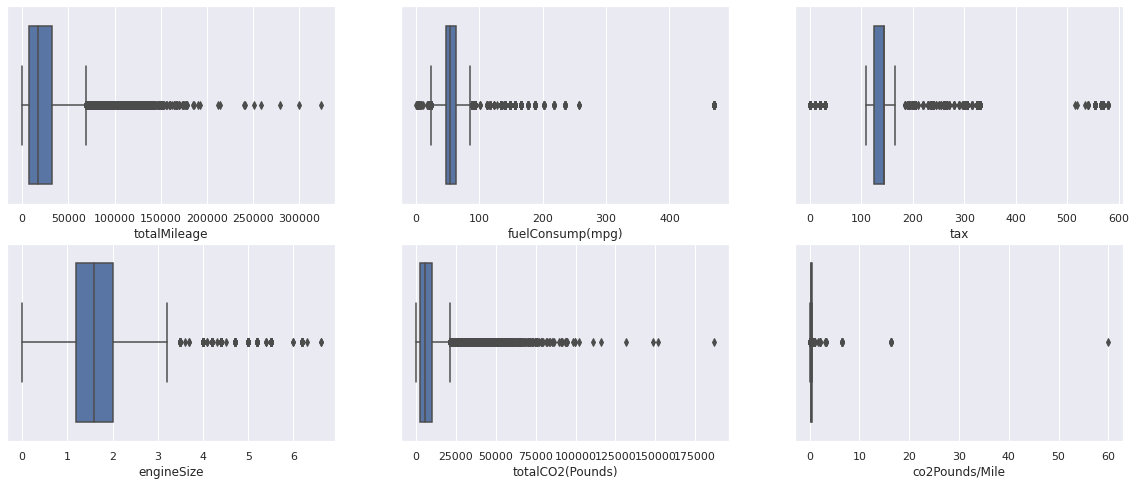

In [ ]:
plt.figure(figsize=(20,8))
for i in enumerate(numeric_var):
  plt.subplot(2,3,i[0]+1)
  sns.boxplot(df[i[1]]);

**totalMileage**

Terlihat distribusinya skewed kekanan. Untuk outliernya, kita akan membiarkannya karena hal tersebut memanglah hal yang bisa terjadi didunia nyata.

**fuelConsump(mpg)**

Terdapat global outlier yang jaraknya lumayan jauh dari data mayoritas. Hasil analisa kita menunjukkan bahwa outlier tersebut dihasilkan oleh mobil hybrid dari BMW model I3. Kita tidak drop outlier tersebut karena memang mobil hybrid lebih irit bahan bakar dibandingkan dengan fuelType petrol ataupun diesel.

In [ ]:
df[df['fuelConsump(mpg)'] == df['fuelConsump(mpg)'].max()].head()

manufacturer model  year  ...  totalCO2(Pounds) co2Pounds/Mile  price
10700          BMW    i3  2016  ...        966.104503       0.038233  17100
11289          BMW    i3  2017  ...       1603.827528       0.038233  19998
11446          BMW    i3  2017  ...       1573.126593       0.038233  19998
11448          BMW    i3  2017  ...        414.405268       0.038233  21898
12534          BMW    i3  2017  ...       1030.947324       0.038233  19980

[5 rows x 12 columns]

**tax**

Berikut adalah sumber yang bisa dijadikan acuan dalam perhitungan pajak mobil di UK :

https://www.which.co.uk/reviews/new-and-used-cars/article/car-tax-explained-aqnPf4D3c26Y

Karena kompleksnya peraturan perpajakan mobil di UK, kita tidak akan melakukan analisa mendalam. 

Analisa singkat dari kita, terdapat 177 mobil yang dikenakan tax lebih dari £500, dari 177 mobil tersebut kebanyakan diisi oleh mobil mewah seperti Ford mustang, Audi R8, Mercedes S Class, dan lain-lain. Mungkin tax diatas £500 itu khusus dikenakan pada mobil mewah saja. Outlier tersebut akan kita biarkan.

Selain itu, kita juga melihat tax yang nilainya nol, hal ini bisa terjadi karena tidak ada quality control dari Exchange and Mart mengenai data yang di input penggunanya, alhasil pengguna dapat melakukan input sesuka hati, salah satunya yaitu mengosongkan beberapa bagian seperti tax dalam kasus kali ini. tax yang bernilai 0 akan kita drop nantinya.

In [ ]:
# tax lebih dari 500
df[df['tax'] > 500].sort_values(by='price',ascending=False).head()

manufacturer      model  year  ...  totalCO2(Pounds) co2Pounds/Mile   price
53632     Mercedes   SL CLASS  2011  ...       2523.364486       0.841121  149948
59289     Mercedes    G Class  2015  ...       8780.487805       0.878049   99850
59239     Mercedes    S Class  2016  ...      18908.962656       0.746888   79950
5980          Audi         R8  2016  ...       7382.903226       0.725806   79900
10072         Audi         R8  2016  ...      21576.099585       0.746888   74500

[5 rows x 12 columns]

In [ ]:
# terdapat 6294 baris tax yang nilainya kosong
df[df['tax']==0].shape[0]

6294

**co2Pounds/Mile**

Terdapat 9 mobil sebagai penghasil polusi tertinggi didata ini. 

Metode perhitungan kita untuk menghitung Co2 adalah sebagai berikut: Untuk setiap galon yang dihabiskan akan menghasilkan 18 pounds CO2, sehingga kolom 'fuelConsump(mpg)' bisa kita manfaatkan sebagai salah satu parameter yang digunakan untuk menghitung seberapa banyak polusi yang dihasilkan per Milesnya.

Agar lebih jelas kita ambil contoh 1 mobil, yaitu Mercedes A Class. Terdapat 1 mobil Mercedes A Class yang sangat boros, konsumsi bahan bakarnya hanya 0.3 Miles/Gallon. Sedangkan jika kita bandingkan dengan mobil Mercedes A Class lainnya, median konsumsi bahan bakarnya dapat mencapai 62.8 Miles/Gallon. Besar kemungkinan hal ini terjadi karena pengiklan tidak mengetahui seberapa banyak fuel consumption yang dihasilkan oleh mobilnya, sehingga mereka mengisinya dengan nilai yang random. Outlier seperti ini akan kita hapus nantinya.

In [ ]:
df[df['co2Pounds/Mile'] > 10].sort_values(by='fuelConsump(mpg)')

manufacturer     model  year  ...  totalCO2(Pounds) co2Pounds/Mile  price
107887           VW   Golf SV  2019  ...       6000.000000      60.000000  17950
48977       Hyundai     Ioniq  2019  ...      46538.181818      16.363636  22998
49575       Hyundai     Ioniq  2020  ...      67941.818182      16.363636  23895
51717       Hyundai     Ioniq  2020  ...      21109.090909      16.363636  26995
53573       Hyundai     Ioniq  2020  ...      85303.636364      16.363636  28995
56151      Mercedes   A Class  2020  ...      65454.545455      16.363636  30231
56187      Mercedes   A Class  2020  ...      65454.545455      16.363636  30231
60597      Mercedes   A Class  2020  ...      16363.636364      16.363636  31500
63993      Mercedes   A Class  2020  ...       5645.454545      16.363636  33900

[9 rows x 12 columns]

In [ ]:
# median fuel consumption mobil Mercedes A Class
df[df['model'] == ' A Class']['fuelConsump(mpg)'].median()

62.8

## Data Correlation

### Heatmap Correlation Matrix

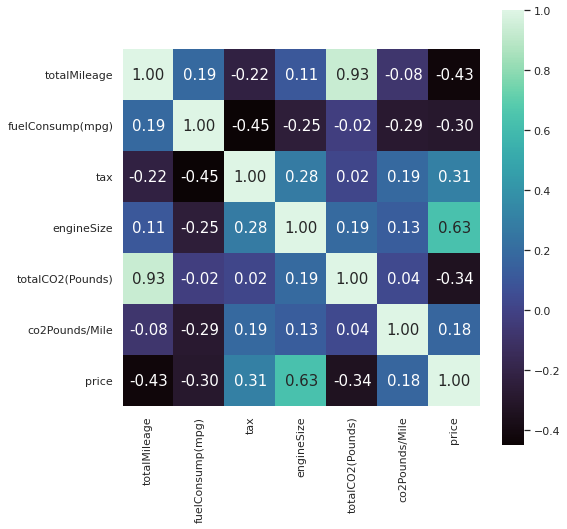

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(df[['totalMileage','fuelConsump(mpg)','tax','engineSize','totalCO2(Pounds)',
                'co2Pounds/Mile', 'price']].corr(),
            cbar=True, annot=True, fmt='.2f', square=True, annot_kws={'size': 15}, cmap='mako');

'totalCO2(Pounds)' memikili korelasi yang tinggi dengan 'totalMileage' sebesar 0.93, untuk menghindari Multicollinearity, kita akan drop salah satunya. Untuk memilih fitur mana yang akan kita drop, kita akan membandingkannya dengan 'price'(target). Hasilnya: 
- 'totalMileage' = -0.43
- 'totalCO2(Pounds)' = -0.34

Karena 'totalMileage' memiliki korelasi terbesar dengan 'price', maka kita akan mempertahankannya, lalu drop fitur 'totalCO2(Pounds)'. Dibawah ini adalah heatmap correlation matrix tanpa fitur 'totalCO2(Pounds)'.

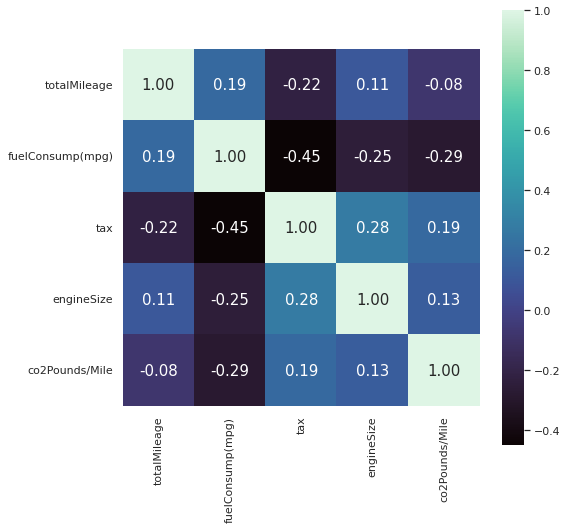

In [ ]:
# setelah drop fitur 'totalCO2(Pounds)'
plt.figure(figsize=(8,8))
sns.heatmap(df[numeric_var].drop(['totalCO2(Pounds)'],axis=1).corr(),
            cbar=True, annot=True, fmt='.2f', square=True, annot_kws={'size': 15},cmap='mako');

### Variance Inflation Factor (VIF)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
def calc_vif(dataset):
    vif = pd.DataFrame()
    vif['variabel'] = dataset.columns
    vif['vif'] = [variance_inflation_factor(dataset.values, i) for i in range(dataset.shape[1])]
    vif.sort_values(by='vif', ascending=False, inplace=True)
    s = [ i for i in range(len(vif))]
    vif.set_index([s], inplace=True)
    return vif 

Karena VIF tidak bisa bekerja jika terdapat missing value, maka kita akan gunakan data copyan yang sudah diimpute dengan knn imputer diatas untuk menghitung VIFnya

In [ ]:
calc_vif(df_copy[numeric_var].astype(int).drop('totalCO2(Pounds)',axis=1))

variabel       vif
0        engineSize  5.881172
1  fuelConsump(mpg)  4.806280
2               tax  4.339757
3      totalMileage  2.323611
4    co2Pounds/Mile  1.000544

Nilai VIF yang lebih besar dari 10 mengindikasikan adanya masalah multikolinearitas yang serius. Karena hasil VIF kita tidak ada yang diatas 10, maka kita akan tetap menggunakan fitur-fitur ini.

### Scatterplot

**Engine Size vs Price**

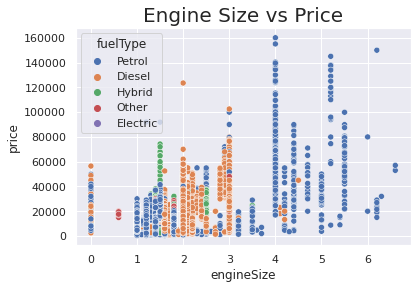

In [ ]:
sns.scatterplot(x=df['engineSize'], y=df['price'], hue=df['fuelType'])
plt.title('Engine Size vs Price', size=20);


Dari visualisasi diatas, terdapat mobil yang memiliki engineSize 0, hal ini dalam dunia nyata tidak mungkin terjadi, meskipun electric car pun seharusnya tetap memilik engine size, contohnya mobil BMW i3 yang sepenuhnya electric tapi memiliki engine size sebesar 0,647 (647cc). maka dari itu data yang seperti ini akan kita kan drop nantinya.

In [ ]:
# jumlah data bermasalah yang memiliki engineSize 0
df[df['engineSize']==0].shape[0]

286

**Fuel Consumption vs Price**

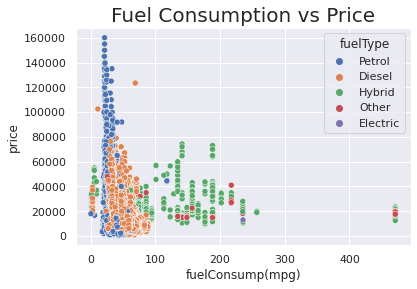

In [ ]:
sns.scatterplot(x=df['fuelConsump(mpg)'], y=df['price'], hue=df['fuelType'])
plt.title('Fuel Consumption vs Price', size=20);

Dari visualisasi diatas, terlihat memang rata-rata mobil hybrid lebih irit bahan bakar dibandingkan dengan Petrol dan Diesel. Pebisnis jual beli mobil bisa merekomendasikan mobil hybrid jika customer menginginkan mobil yang irit bahan bakar.

**Year vs Price**

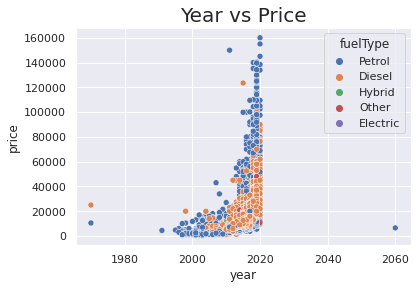

In [ ]:
sns.scatterplot(x=df['year'], y=df['price'], hue=df['fuelType'])
plt.title('Year vs Price', size=20);

Trend penurunan harga mobil berdasarkan tahun terlihat eksponensial, penurunan harga terbesar terjadi pada 10 tahun pertama usia mobil, setelah itu penurunannya mulai melandai.

**Total Mileage vs Price**

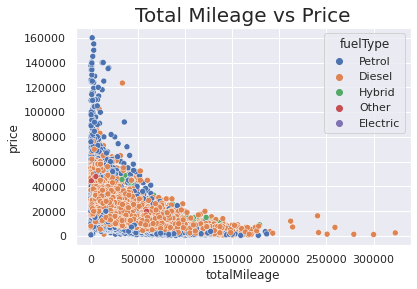

In [ ]:
sns.scatterplot(x=df['totalMileage'], y=df['price'], hue=df['fuelType'])
plt.title('Total Mileage vs Price', size=20);

Semakin besar Total Mileage, Pricenya pun menjadi semakin rendah. Salah satu cara untuk mengurangi efek depresiasi adalah dengan mengurangi bepergian ke tempat yang tidak terlalu penting menggunakan kendaraan anda.

## Data Cardinality

### Countplot

**model**

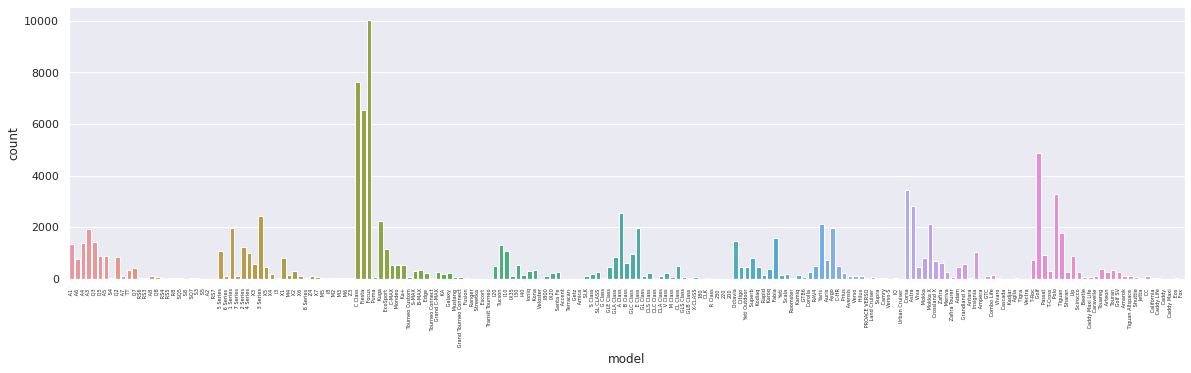

In [ ]:
plt.figure(figsize=(20,5))
sns.countplot(df['model'])
plt.xticks(size=5, rotation='90');

Data categoric dengan cardinalitas yang tinggi dapat membuat jumlah kolom membengkak jika kita transform menggunakan OneHotEncoder. Untuk itu, fitur 'model' akan kita encode dengan BinaryEncoder agar tidak terjadi pembengkakkan fitur.

**manufacturer, transmission, fuelType**

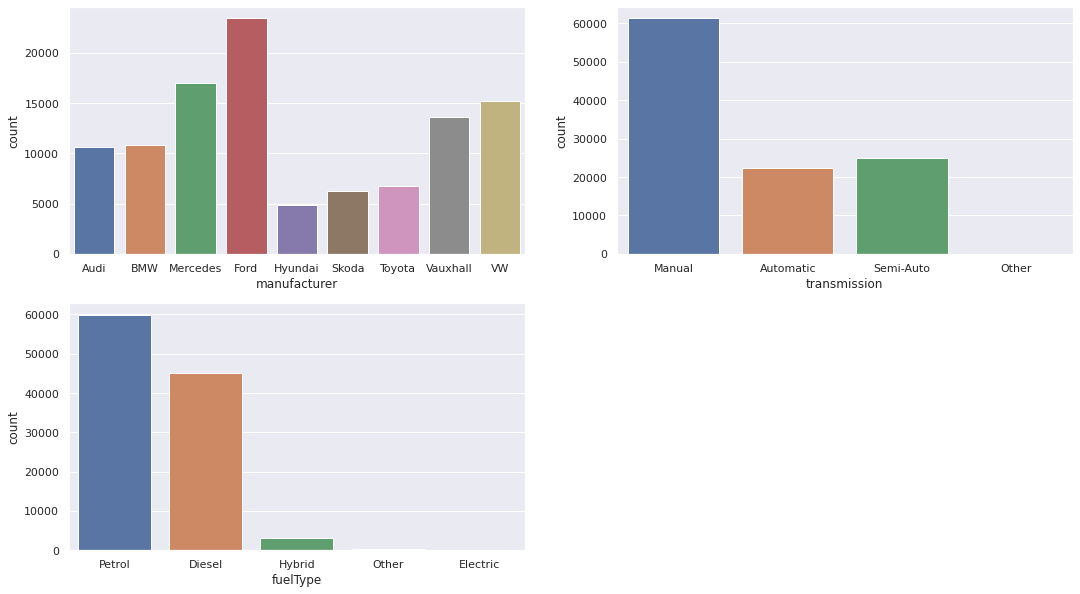

In [ ]:
plt.figure(figsize=(18, 10))
for i in enumerate(['manufacturer', 'transmission', 'fuelType']):
  plt.subplot(2,2,i[0]+1)
  sns.countplot(df[i[1]]);

Di kolom 'transmission' dan 'fuelType' terdapat class 'Other', class ini sebenarnya adalah missing value. Nantinya kita akan drop class ini. Alasannya karena jika kita impute lalu hasil impute nya tidak tepat, maka hanya akan menjadi noise, dimana hal ini bukanlah hal yang bagus bagi model kita nantinya, hasil prediksi kita menjadi kurang tepat karena model kita belajar dari data yang jelek kualitasnya. Pertimbangan lainnya karena data yang di drop jumlahnya relatif sedikit, jadi lebih baik di drop saja.

In [ ]:
# terdapat 10 baris kolom 'transmission' berkategori 'Other'
df[df['transmission'] == 'Other'].shape[0]

10

In [ ]:
# terdapat 253 baris kolom 'fuelType' berkategori 'Other'
df[df['fuelType'] == 'Other'].shape[0]

253

**year**

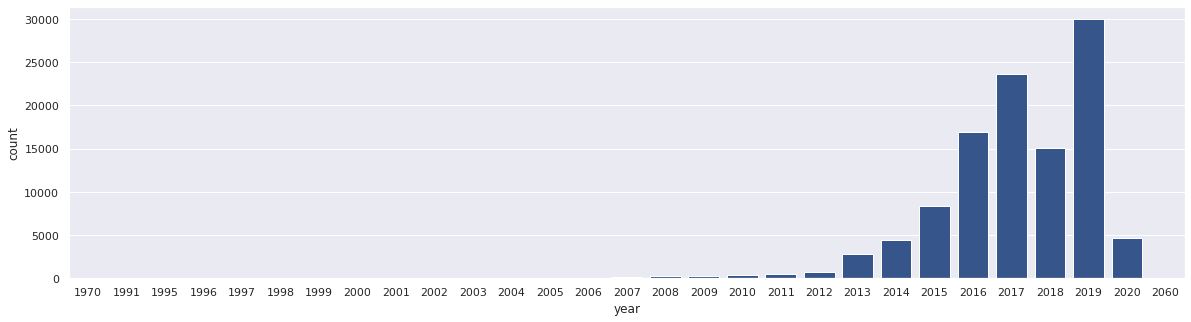

In [ ]:
plt.figure(figsize=(20,5))
sns.countplot(df['year'], color='#285399');

Data kita didominasi oleh mobil-mobil keluaran tahun 2000 keatas, hal ini menandakan sedikitnya section mobil classic yang ada di Exchange and Mart (Exchange and Mart menganggap mobil yang berusia diatas 25 tahun sebagai mobil classic).

In [ ]:
# hanya ada 4 mobil dengan usia diatas 25 tahun
df[df['year']<=1995]

manufacturer     model  year  ...  totalCO2(Pounds) co2Pounds/Mile  price
24906     Mercedes   C Class  1991  ...               NaN            NaN   4450
24961     Mercedes   C Class  1995  ...               NaN            NaN   4750
65699     Mercedes   M Class  1970  ...       6428.571429       0.459184  24999
90588     Vauxhall    Zafira  1970  ...      15934.265403       0.426540  10495

[4 rows x 12 columns]

**Ford, Mercedes, VW**

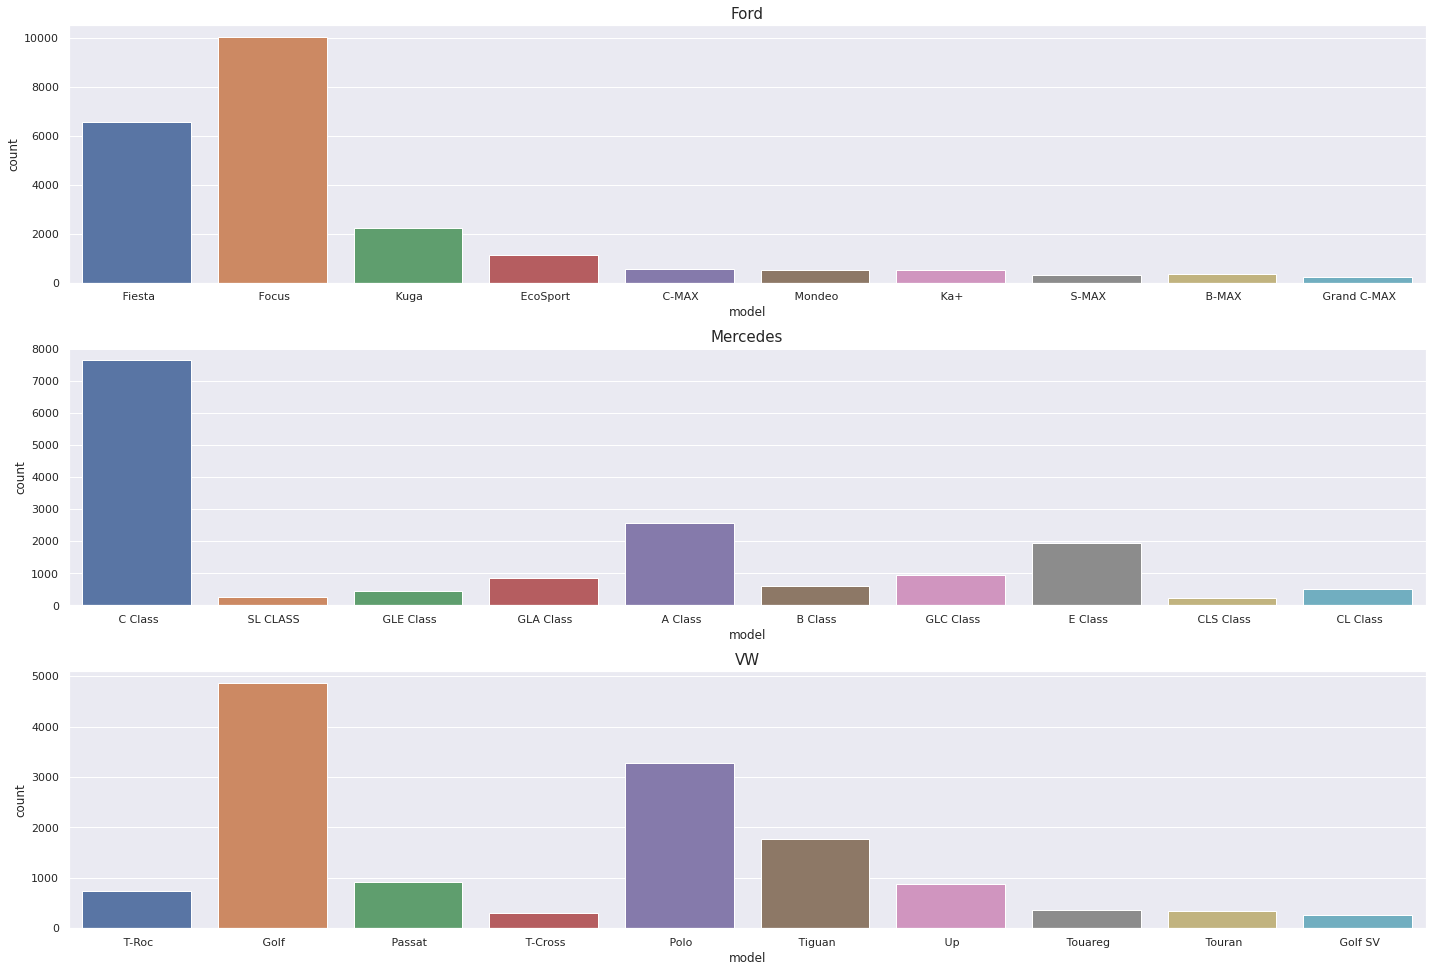

In [ ]:
plt.figure(figsize=(20,40))
for i in enumerate(['Ford', 'Mercedes', 'VW']):
    plt.tight_layout()
    plt.subplot(9,1,i[0]+1)
    plt.title(i[1], size=15)
    sns.countplot(
    df[(df['manufacturer'] == i[1]) & (df['model'].isin(list(dict(df[(df['manufacturer'] == i[1])]['model'].value_counts().head(10)).keys())))]['model']
    )

Manufacturer terbesar di data ini adalah Ford, Mercedes, dan VW. Dengan model terbanyaknya secara berurutan ada Focus, C Class, dan Golf. Info ini bisa menjadi bahan evaluasi client kita dalam menentukan strategi penjualannya, misal agar tidak terlalu bersaing dengan penjual yang lain, disarankan untuk tidak membeli mobil dengan model yang disebutkan diatas.

## Identify missing value, outlier dan duplicate

### Missing Value

In [ ]:
#melihat setiap kolom yang memilki missing value
df.isnull().sum()

manufacturer           0
model                  0
year                   0
totalMileage           0
transmission           0
fuelType               0
fuelConsump(mpg)    9353
tax                 9353
engineSize             0
totalCO2(Pounds)    9353
co2Pounds/Mile      9353
price                  0
dtype: int64

In [ ]:
# buat Dataframe total missing value dan persentasenya
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Percent'] > 0]
missing_data

Total   Percent
co2Pounds/Mile     9353  0.086171
totalCO2(Pounds)   9353  0.086171
tax                9353  0.086171
fuelConsump(mpg)   9353  0.086171

Terdapat sekitar 8% missing value, nantinya akan kita impute pada bagian preprocessing.

### Outlier Berdasarkan price

Untuk outliers, kita hanya akan melakukan drop pada outlier global, dan tetap mempertahankan outlier collective, karena kita tidak ingin kehilangan informasi di rentang harga prediksi yang lebih tinggi.

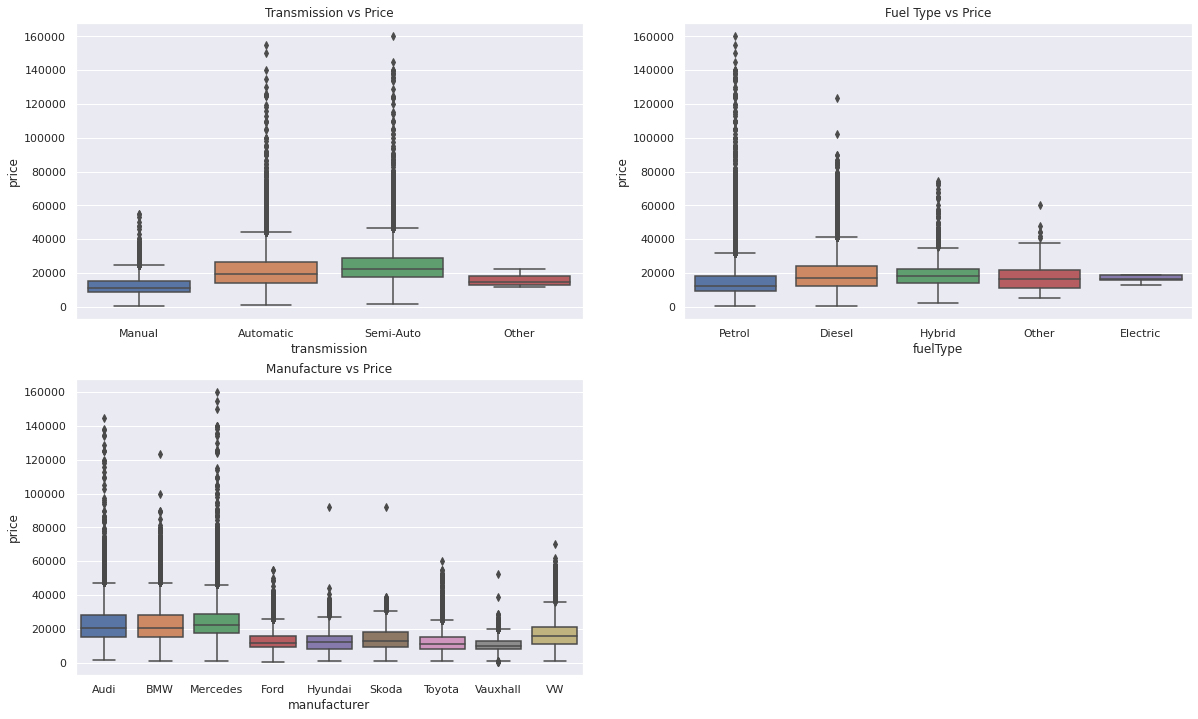

In [ ]:
#melihat data outlier menggunakan ploting boxplot terhadap data price
plt.figure(figsize=(20, 12))

plt.subplot(221)
sns.boxplot(x = 'transmission', y=df['price'], data = df)
plt.title('Transmission vs Price')

plt.subplot(222)
sns.boxplot(x = 'fuelType', y=df['price'], data = df)
plt.title('Fuel Type vs Price')

plt.subplot(223)
sns.boxplot(x = 'manufacturer', y=df['price'], data = df)
plt.title('Manufacture vs Price');

In [ ]:
# IQR function
def iqr(datacolumn):
    sorted(datacolumn)
    Q1,Q2,Q3 = np.percentile(datacolumn , [25,50,75])
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    return pd.DataFrame({
    'attribute':['lower_bound', 'Q1', 'Q2','Q3','upper_bound', 'IQR'],
    'result':[lower_bound,Q1,Q2,Q3,upper_bound,IQR ]
})

**Hyundai**

Kita mendapati outlier Hyundai I10 dengan harga £92000, kalau kita bandingkan dengan upper bound Hyundai I10 yang hanya berkisar £11742 saja, maka dapat dipastikan harga £92000 bukanlah harga yang wajar. Kita juga melakukan riset harga baru mobil ini, dan memang harga barunya hanya berkisar diantara £12000 - £13000. Kemungkinan pengguna tersebut ingin menjual mobilnya dengan harga £9200, namun nolnya kelebihan satu. Nantinya outlier ini akan kita drop.

In [ ]:
df[df['manufacturer'] == 'Hyundai'].sort_values(by='price', ascending=False).head(1)

manufacturer model  year  ...  totalCO2(Pounds) co2Pounds/Mile  price
53014      Hyundai   I10  2017  ...       13325.26096       0.375783  92000

[1 rows x 12 columns]

In [ ]:
iqr(df[df['model'] == ' I10']['price'])

attribute     result
0  lower_bound   3353.125
1           Q1   6499.000
2           Q2   7495.000
3           Q3   8596.250
4  upper_bound  11742.125
5          IQR   2097.250

**Skoda**

Hal yang sama terjadi pada Skoda Karoq, £91874 bukanlah harga yang normal untuk mobil ini, harga ini jauh diatas upper bound Skoda karoq yang hanya £29745. Setelah kita riset, harga barunya sekitar £33000. Sehingga outlier ini akan kita drop juga nantinya. 

In [ ]:
df[df['manufacturer'] == 'Skoda'].sort_values(by='price', ascending=False).head(1) 

manufacturer   model  year  ...  totalCO2(Pounds) co2Pounds/Mile  price
71739        Skoda   Karoq  2019  ...       1656.528117       0.440098  91874

[1 rows x 12 columns]

In [ ]:
# Skoda Karoq
iqr(df[df['model'] == ' Karoq']['price'])

attribute   result
0  lower_bound  11745.0
1           Q1  18495.0
2           Q2  19999.0
3           Q3  22995.0
4  upper_bound  29745.0
5          IQR   4500.0

**BMW**

Harga baru BMW 2 Series tahun 2015 berkisar antara £32000 - £33000, upper bound untuk model ini sebesar £34174, sehingga harga £123456 bukanlah harga yang wajar. Kita akan drop outlier ini.

In [ ]:
df[df['manufacturer'] == 'BMW'].sort_values(by='price', ascending=False).head(1) 

manufacturer      model  year  ...  totalCO2(Pounds) co2Pounds/Mile   price
14306          BMW   2 Series  2015  ...        8730.65312       0.261248  123456

[1 rows x 12 columns]

In [ ]:
# BMW 2 Series
iqr(df[df['model'] == ' 2 Series']['price'])

attribute   result
0  lower_bound   4042.5
1           Q1  15342.0
2           Q2  19980.0
3           Q3  22875.0
4  upper_bound  34174.5
5          IQR   7533.0

**Vauxhall**

vauxhall memiliki 2 global outlier, yaitu model Mokka dengan harga £52489, dan Insignia dengan harga £39000. 

Kita bahas dari model Mokka terlebih dahulu, jika dibandingkan dengan upperboundnya yang sebesar 12329£, tentu harga £52489 sangatlah jauh sekali. Berdasarkan riset, kita mendapatkan harga baru model Mokka tahun 2016 di sekitaran £16,604 - £25,264. Kita akan drop oulier ini.

Selanjutnya adalah Vauxhall Insignia tahun 2020 dengan harga £39000, kita menemukan harga barunya berada direntang £23120 - £38850 MSRPnya (Manufacturer's Suggested Retail Price), sehingga kita menganggap harga 39000 adalah harga yang masih wajar. kita tidak akan drop outlier ini.

In [ ]:
df[df['manufacturer'] == 'Vauxhall'].sort_values(by='price', ascending=False).head(2)

manufacturer      model  year  ...  totalCO2(Pounds) co2Pounds/Mile  price
86793     Vauxhall      Mokka  2016  ...      17054.187726       0.324910  52489
92622     Vauxhall   Insignia  2020  ...        490.463215       0.490463  39000

[2 rows x 12 columns]

In [ ]:
# Vauxhall Mokka
iqr(df[df['model'] == ' Mokka']['price'])

attribute   result
0  lower_bound   5369.5
1           Q1   7979.5
2           Q2   8795.0
3           Q3   9719.5
4  upper_bound  12329.5
5          IQR   1740.0

In [ ]:
# Vauxhall Insignia
iqr(df[df['model'] == ' Insignia']['price'])

attribute     result
0  lower_bound  -1021.375
1           Q1   8290.250
2           Q2  11998.000
3           Q3  14498.000
4  upper_bound  23809.625
5          IQR   6207.750

### Duplicate

In [ ]:
# Cek duplikasi rows
duplicate_rows_df = df[df.duplicated()]
print('Jumlah rows yang terduplikasi: ', duplicate_rows_df.shape[0]) 

Jumlah rows yang terduplikasi:  2273


Terdapat rows yang terduplikasi, namun kita tidak akan drop rows yang terduplikasi ini, karena memang didunia nyata hal ini bisa saja terjadi. Misal, kita ingin menjual mobil 'A' dengan harga 99 poundsterling, tentu saja yang ingin menjual mobil 'A' dengan harga 99 poundsterling bukan hanya kita saja, kebetulan seperti itu bisa saja terjadi.

# **Preprocessing**

## Menghapus tahun diatas 2020

In [ ]:
df['year'].unique()

array([2017, 2016, 2019, 2015, 2014, 2018, 2013, 2020, 2004, 2009, 2012,
       2010, 2007, 2011, 2008, 2003, 2005, 2002, 2006, 1998, 1997, 2001,
       2000, 1999, 1996, 1991, 1995, 2060, 1970])

Terdapat tahun yang tidak wajar, yaitu tahun 2060

In [ ]:
df = df[df['year'] != 2060]

In [ ]:
df['year'].unique()

array([2017, 2016, 2019, 2015, 2014, 2018, 2013, 2020, 2004, 2009, 2012,
       2010, 2007, 2011, 2008, 2003, 2005, 2002, 2006, 1998, 1997, 2001,
       2000, 1999, 1996, 1991, 1995, 1970])

Dapat dilihat diatas tahun 2060 sudah hilang, dapat dibuktikan dibawah ini :

In [ ]:
df[df['year'] == 2060]

Empty DataFrame
Columns: [manufacturer, model, year, totalMileage, transmission, fuelType, fuelConsump(mpg), tax, engineSize, totalCO2(Pounds), co2Pounds/Mile, price]
Index: []

In [ ]:
# jangan lupa reset index setelah menghapus data yang bermasalah agar indexnya kembali seperti semula
df.reset_index(drop=True, inplace=True)

## Drop Outlier



In [ ]:
# drop outlier 'co2Pounds/Mile'
df.drop(df[df['co2Pounds/Mile'] > 10].index,inplace=True)

In [ ]:
# drop Hyundai 
df.drop(df[df['model'] == ' I10'].sort_values(by='price',ascending=False).head(1).index, inplace=True)

# drop Skoda
df.drop(df[df['model'] == ' Karoq'].sort_values(by='price',ascending=False).head(1).index, inplace=True)

# drop BMW
df.drop(df[df['model'] == ' 2 Series'].sort_values(by='price',ascending=False).head(1).index, inplace=True)

# drop Vauxhall
df.drop(df[df['model'] == ' Mokka'].sort_values(by='price',ascending=False).head(1).index, inplace=True)

# jangan lupa reset index setelah menghapus data yang bermasalah agar indexnya kembali seperti semula
df.reset_index(drop=True, inplace=True)

## Drop transmission 'Other'

In [ ]:
# hapus transmission 'Other'
df.drop(df[df['transmission'] == 'Other'].index, inplace=True)

# jangan lupa reset index setelah menghapus data yang bermasalah agar indexnya kembali seperti semula
df.reset_index(drop=True, inplace=True)

In [ ]:
# transmission 'Other' sudah hilang
df['transmission'].unique()

array(['Manual', 'Automatic', 'Semi-Auto'], dtype=object)

## Drop fuelType 'Other'

In [ ]:
# hapus fuelType 'Other'
df.drop(df[df['fuelType'] == 'Other'].index, inplace=True)

# jangan lupa reset index setelah menghapus data yang bermasalah agar indexnya kembali seperti semula
df.reset_index(drop=True, inplace=True)

In [ ]:
# fuelType 'Other' sudah hilang
df['fuelType'].unique()

array(['Petrol', 'Diesel', 'Hybrid', 'Electric'], dtype=object)

## Drop engineSize = 0

In [ ]:
# hapus engineSize = 0
df.drop(df[df['engineSize']==0].index, inplace=True)

# jangan lupa reset index setelah menghapus data yang bermasalah agar indexnya kembali seperti semula
df.reset_index(drop=True, inplace=True)

In [ ]:
# cek untuk melihat apakah masih ada engineSize = 0
df[df['engineSize']==0]

Empty DataFrame
Columns: [manufacturer, model, year, totalMileage, transmission, fuelType, fuelConsump(mpg), tax, engineSize, totalCO2(Pounds), co2Pounds/Mile, price]
Index: []

## Drop tax = 0

In [ ]:
# hapus tax bernilai 0
df.drop(df[df['tax']==0].index, inplace=True)

# jangan lupa reset index setelah menghapus data yang bermasalah agar indexnya kembali seperti semula
df.reset_index(drop=True, inplace=True)

In [ ]:
# cek untuk melihat apakah masih ada tax = 0
df[df['tax']==0]

Empty DataFrame
Columns: [manufacturer, model, year, totalMileage, transmission, fuelType, fuelConsump(mpg), tax, engineSize, totalCO2(Pounds), co2Pounds/Mile, price]
Index: []

# **Model**

## Stratified Random Sampling for Machine Learning

Karena data aslinya terlalu besar (ada lebih dari 100000 baris), dan untuk menghemat waktu komputasi juga, kita putuskan untuk melakukan sampling dengan n_sample sebesar 60000 baris. Kita melakukan sampling dengan metode Stratified Random Sampling agar proporsi strata yang ada di data populasi tetap sama proporsinya dengan data sample yang akan kita ambil. Strata yang digunakan adalah manufacturernya (Audi, BMW, Ford, dan lain-lain).

Rumus perhitungannya kita dapatkan dari sumber berikut:
https://youtu.be/ZDDybDAJMSw

In [ ]:
# copy dari data asli agar tidak saling tumpang tindih
df_all = df.copy()
df_all

manufacturer model  year  ...  totalCO2(Pounds) co2Pounds/Mile  price
0              Audi    A1  2017  ...       5112.454874       0.324910  12500
1              Audi    A6  2016  ...      10150.373832       0.280374  16500
2              Audi    A1  2016  ...       9729.747292       0.324910  11000
3              Audi    A4  2017  ...       6941.099554       0.267459  16800
4              Audi    A3  2019  ...        725.080645       0.362903  17300
...             ...   ...   ...  ...               ...            ...    ...
101781           VW   Eos  2012  ...      22614.601019       0.305603   5990
101782           VW   Fox  2008  ...      34251.317495       0.388769   1799
101783           VW   Fox  2009  ...      30000.000000       0.428571   1590
101784           VW   Fox  2006  ...      32152.742981       0.388769   1250
101785           VW   Fox  2007  ...      28768.898488       0.388769   2295

[101786 rows x 12 columns]

In [ ]:
# proporsi strata before sampling dan after sampling, terlihat proporsinya identik
df_manu_proportion = pd.DataFrame(df_all['manufacturer'].value_counts()).reset_index()
df_manu_proportion = df_manu_proportion.rename(columns={'index':'manufaturer', 'manufacturer':'count_before'})
df_manu_proportion['percentage_before'] = [i/df_all['manufacturer'].count() for i in df_manu_proportion['count_before']]
df_manu_proportion['count_after'] = [round((i/df_all['manufacturer'].count())*60000)  for i in df_manu_proportion['count_before']]
df_manu_proportion['percentage_after'] = [i/60000 for i in df_manu_proportion['count_after']]
df_manu_proportion 

manufaturer  count_before  percentage_before  count_after  percentage_after
0        Ford         21209           0.208369        12502          0.208367
1    Mercedes         16820           0.165249         9915          0.165250
2          VW         14470           0.142161         8530          0.142167
3    Vauxhall         13237           0.130047         7803          0.130050
4         BMW         10403           0.102205         6132          0.102200
5        Audi         10075           0.098982         5939          0.098983
6       Skoda          6034           0.059281         3557          0.059283
7      Toyota          4866           0.047806         2868          0.047800
8     Hyundai          4672           0.045900         2754          0.045900

In [ ]:
# ini adalah dataframe hasil Stratified Random Sampling
ford = df_all[df_all['manufacturer'] == 'Ford'].sample(n=12502, random_state=42)
mercedes = df_all[df_all['manufacturer'] == 'Mercedes'].sample(n=9915, random_state=42)
vw = df_all[df_all['manufacturer'] == 'VW'].sample(n=8530, random_state=42)
vauxhall = df_all[df_all['manufacturer'] == 'Vauxhall'].sample(n=7803, random_state=42)
bmw = df_all[df_all['manufacturer'] == 'BMW'].sample(n=6132, random_state=42)
audi = df_all[df_all['manufacturer'] == 'Audi'].sample(n=5939, random_state=42)
toyota = df_all[df_all['manufacturer'] == 'Toyota'].sample(n=3557, random_state=42)
skoda = df_all[df_all['manufacturer'] == 'Skoda'].sample(n=2868, random_state=42)
hyundai = df_all[df_all['manufacturer'] == 'Hyundai'].sample(n=2754, random_state=42)

df_strat = pd.concat([ford, mercedes, vw, vauxhall, bmw, audi, toyota, skoda, hyundai])
df_strat.reset_index(drop=True, inplace=True)
df_strat

manufacturer      model  year  ...  totalCO2(Pounds) co2Pounds/Mile  price
0             Ford     Fiesta  2018  ...       3608.219178       0.273973   9790
1             Ford   EcoSport  2016  ...       7570.093458       0.280374   8614
2             Ford       Kuga  2016  ...      12824.419890       0.331492  13499
3             Ford      Focus  2017  ...       8109.105058       0.350195  11250
4             Ford      Focus  2017  ...               NaN            NaN  11900
...            ...        ...   ...  ...               ...            ...    ...
59995      Hyundai       Kona  2019  ...       4688.979592       0.408163  15539
59996      Hyundai   Santa Fe  2017  ...      14890.373832       0.420561  19770
59997      Hyundai        I10  2018  ...       3027.306889       0.375783  12499
59998      Hyundai     Tucson  2017  ...       4869.944751       0.331492  15469
59999      Hyundai     Tucson  2017  ...       9735.267857       0.401786  12490

[60000 rows x 12 columns]

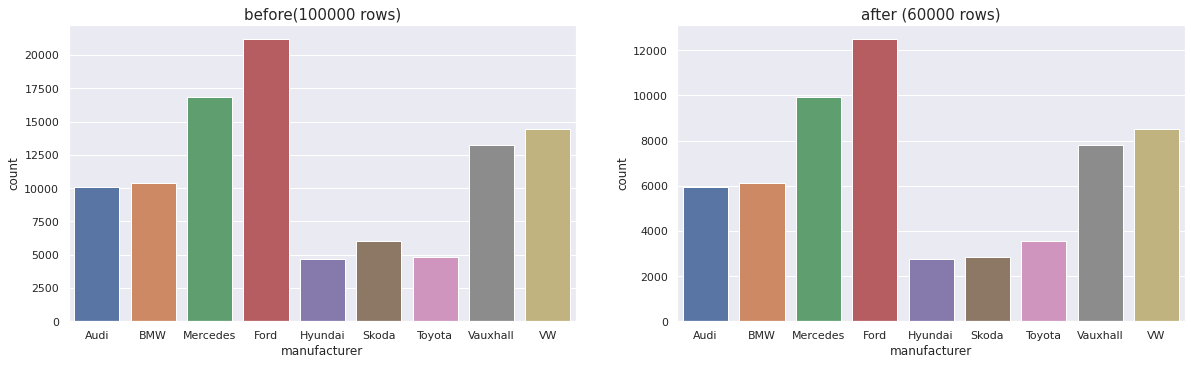

In [ ]:
# kita buktikan dengan visualisasi agar lebih jelas kalau proporsinya sama

plt.figure(figsize=(20, 12))

# Data asli
plt.subplot(221)
plt.title('before(100000 rows)', size=15)
sns.countplot(df_all['manufacturer'])

# Data sampling
plt.subplot(222)
plt.title('after (60000 rows)', size=15)
order = ['Audi', 'BMW', 'Mercedes', 'Ford', 'Hyundai', 'Skoda', 'Toyota', 'Vauxhall', "VW"]
sns.countplot(df_strat['manufacturer'], order=order);

In [ ]:
# describe data yang barisnya 100000

df_all.describe()

year   totalMileage  ...  co2Pounds/Mile          price
count  101786.000000  101786.000000  ...    92453.000000  101786.000000
mean     2017.184495   22240.484634  ...        0.353179   17304.982247
std         2.135068   20975.945688  ...        0.106525    9846.810489
min      1970.000000       1.000000  ...        0.070093     450.000000
25%      2016.000000    7000.000000  ...        0.299501   10500.000000
50%      2017.000000   16228.500000  ...        0.331492   15000.000000
75%      2019.000000   31127.000000  ...        0.394737   21399.750000
max      2020.000000  323000.000000  ...        6.428571  159999.000000

[8 rows x 8 columns]

In [ ]:
# describe data yang barisnya 60000

df_strat.describe()

year   totalMileage  ...  co2Pounds/Mile          price
count  60000.000000   60000.000000  ...    54550.000000   60000.000000
mean    2017.175867   22229.740933  ...        0.353211   17307.072433
std        2.147614   20943.658086  ...        0.107502    9897.914085
min     1970.000000       1.000000  ...        0.070093     450.000000
25%     2016.000000    7000.000000  ...        0.299501   10500.000000
50%     2017.000000   16212.500000  ...        0.331492   15000.000000
75%     2019.000000   31146.250000  ...        0.394737   21450.000000
max     2020.000000  323000.000000  ...        6.428571  159999.000000

[8 rows x 8 columns]

Terlihat keduanya memiliki karakteristik yang hampir mirip, bagaimana dengan data categoricnya? mari kita lihat 

In [ ]:
df_all.describe(include=object)

manufacturer   model transmission fuelType
count        101786  101786       101786   101786
unique            9     192            3        3
top            Ford   Focus       Manual   Petrol
freq          21209    9510        56539    57372

In [ ]:
df_strat.describe(include=object)

manufacturer   model transmission fuelType
count         60000   60000        60000    60000
unique            9     188            3        3
top            Ford   Focus       Manual   Petrol
freq          12502    5512        33285    33871

Keduanya masih mirip, hanya saja kita kehilangan 10 model. namun tidak masalah karena 10 model tersebut adalah outlier, kecil kemungkinan kita akan memprediksi model mobil tersebut.

## Feature Engineering Pipeline

Berikut adalah skema preprocessing yang akan kita lakukan, kita bagi tipe datanya menjadi 3 kategori. Numeric, Ordinal, dan Nominal.

Numeric: 
1. Pertama kita impute dengan KNN imputer, kita pilih KNN imputer karena KNN imputer lebih robust hasilnya dibandingkan dengan SimpleImputer, KNN imputer mempertimbangkan kolom numeric lain sebagai bahan pertimbangan value apa yang akan di imputekan (multivariat), sedangkan Simple Imputer pertimbangannya hanya berdasarkan satu kolom saja (univariat). 

2. Tahap selanjutnya, karena bentuk distribusi fitur numeric yang kita punya tidaklah normal, untuk mengatasinya kita akan scaling untuk menyamakan skala fiturnya, lalu kita transform dengan yeo-johnson agar fiturnya lebih mendekati distribusi normal. fitur numeric yang berskala mirip dan mendekati distribusi normal dapat membantu meningkatkan score model (tree base model tidak mendapatkan efek dari transformasi ini)

3. variabel yang digunakan: 'tax', 'fuelConsump(mpg)', 'engineSize', 'co2Pounds/Mile'

Ordinal:
1. Berdasarkan fakta bahwa secara umum mobil tua valuenya lebih rendah dibandingkan dengan mobil yang lebih muda, tingkatan seperti inilah yang membuat kita akhirnya memutuskan untuk memasukkan 'year' kedalam Ordinal. Kita akan encode data Ordinal ini menggunakan OrdinalEncoder

Nominal:
1. berikut adalah fitur-fitur yang kita masukkan kedalam kategori Nominal,'transmission', 'manufacturer', 'fuelType', 'model'. Fitur-fitur berikut kita anggap Nominal karena fitur-fitur tersebut merupakan hasil dari preferensi pengguna, dimana preferensi tidak memiliki tingkatan value seperti kategori Ordinal. Untuk proses Encodingnya, seluruh kategori Nominal kita Encode menggunakan OneHotEncoder, kecuali 'model', karena model memiliki class yang banyak, maka kita gunakan BinaryEncoder.


In [ ]:
# imputer
imputer = KNNImputer(n_neighbors=5)

# numeric
num_var = [ 'tax', 'fuelConsump(mpg)', 'engineSize', 'co2Pounds/Mile', 'totalMileage']
scaler = StandardScaler()
power = PowerTransformer(method='yeo-johnson')
numeric_pipe = Pipeline([
    ('imputer', imputer),
    ('scaler', scaler),
    ('power', power)  
])

# ordinal
ordinal_var = ['year']
year_map = list(range(1970,2021))
ordinal_encoder = OrdinalEncoder(categories=[year_map])
ordinal_pipe = Pipeline([
    ('ordinal_encoder', ordinal_encoder)
])

# nominal (Onehot)
nominal_var = ['transmission', 'manufacturer', 'fuelType']
most_freq_imputer = SimpleImputer(strategy='most_frequent')
nominal_encoder = OneHotEncoder(handle_unknown='ignore')
nominal_pipe = Pipeline([
    ('most_freq_imputer', most_freq_imputer),
    ('nominal_encoder', nominal_encoder)
])

#nominal(Binary)
nominal_binary_var = ['model']
nominal_binary_encoder = ce.BinaryEncoder()
nominal_binary_pipe = Pipeline([
    ('nominal_binary_encoder', nominal_binary_encoder)
])

## Transformer

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric_pipe', numeric_pipe, num_var),
    ('ordinal_pipe', ordinal_pipe, ordinal_var),
    ('nominal_pipe', nominal_pipe, nominal_var),
    ('nominal_binary_pipe', nominal_binary_pipe, nominal_binary_var)
])

## Dataset Splitting

Kita split data dengan proporsi data train 80%, data Test 20%.

In [ ]:
# sesuai dengan hasil correlation matrix dan VIF, 'totalCO2(Pounds)' tidak diikutkan kedalam model
X = df_strat.drop(columns=['price', 'totalCO2(Pounds)'])
y = df_strat['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((48000, 10), (12000, 10), (48000,), (12000,))

## Cross Validation

Empat model berikut kita pilih sebagai base model karena keempatnya memiliki cara kerja yang berbeda. Ditahap ini kita ingin mengetahui base model mana yang terbaik untuk selanjutnya di optimasi menggunakan hyperparameter tuning.

In [ ]:
models = [
    ['Linear Regression', LinearRegression()],
    ['KNN', KNeighborsRegressor()],
    ['Random Forest', RandomForestRegressor(random_state=42)],
    ['XGB', xgb.XGBRegressor(verbosity=0)]
]

In [ ]:
def cross_validation(model):
    model_name = []

    cv_r2_mean = []
    cv_r2_std = []
    training_r2 = []

    cv_rmse_mean = []
    cv_rmse_std = []
    training_rmse = []

    cv_mae_mean = []
    cv_mae_std = []
    training_mae = []
    for name, model in models:
    
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ]) 
        model_name.append(name)

        #scoring
        scoring= ['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']

        # test
        cv_score = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=10, n_jobs=-1)

        cv_r2_mean.append(cv_score['test_r2'].mean())
        cv_r2_std.append(cv_score['test_r2'].std())

        cv_rmse_mean.append(abs(cv_score['test_neg_root_mean_squared_error']).mean())
        cv_rmse_std.append(abs(cv_score['test_neg_root_mean_squared_error']).std())

        cv_mae_mean.append(abs(cv_score['test_neg_mean_absolute_error']).mean())
        cv_mae_std.append(abs(cv_score['test_neg_mean_absolute_error']).std())

        # training
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_train)
        training_r2.append(r2_score(y_train,y_pred))
        training_rmse.append(np.sqrt(mean_squared_error(y_train,y_pred)))
        training_mae.append(mean_absolute_error(y_train, y_pred))
    
    return pd.DataFrame({
        'Model': model_name,
        'Training r2': training_r2,
        'CV R2 (mean)': cv_r2_mean,
        'CV R2 (std)' : cv_r2_std,
        'Training RMSE' : training_rmse,
        'CV RMSE (mean)': cv_rmse_mean,
        'CV RMSE (std)': cv_rmse_std,
        'Training MAE' : training_mae,
        'CV MAE (mean)' : cv_mae_mean,
        'CV MAE (std)' : cv_mae_std
    })

In [ ]:
cv_result = cross_validation(models)
cv_result

Model  Training r2  ...  CV MAE (mean)  CV MAE (std)
0  Linear Regression     0.780496  ...    2970.262730     52.026968
1                KNN     0.965760  ...    1338.554996     33.077066
2      Random Forest     0.993237  ...    1252.226791     30.662753
3                XGB     0.902682  ...    2120.587836     34.168789

[4 rows x 10 columns]

Dari kesimpulan diatas kita pilih Random Forest untuk lanjut ke tahap optimasi karena model ini memiliki nilai error RMSE dan MAE yang lebih kecil dibandingkan dengan model lainnya, standard deviasi errornya pun masih relatif stabil. Selain itu nilai cv R2 nya yang lebih tinggi dibandingkan dengan model yang lain juga menjadi nilai plus untuk RF.

## New Feature Engineering

Overall hasil score modelnya sudah bagus, hanya saja beberapa teknik feature engineering yang kita lakukan sebelumnya membuat model ini kurang interpretable. Contohnya untuk fitur numerik, kita sulit untuk melihat value aslinya karena sudah di scaling dan transform, hal ini akan membuat bingung client kita nantinya.

Karena kebetulan base model terbaik untuk data ini adalah Random Forest, dan Random Forest juga dapat melakukan pemodelan dengan baik meskipun skala fitur numeriknya tidak sama dan distribusi data fiturnya tidak normal, untuk itu kita akan coba membuat model baru menggunakan feature engineering yang tidak terlalu merubah fitur aslinya, lalu kita bandingkan dengan model sebelumnya, akankah hasilnya lebih baik, sama saja, atau malah memburuk.

### Feature Extraction

Untuk mengatasi cardinalitas yang tinggi di fitur 'model' kita akan melakukan feature engineering dengan cara kita hanya melihat 10 model yang frekuensi kemunculannya paling tinggi, selain dari 10 model itu akan kita anggap model 'Other'. Dengan cara seperti ini yang sebelumnya fitur model memiliki class sebanyak 195, sekarang hanya menjadi 11 saja. fitur ini akan kita namakan "model2".

In [ ]:
most_freq_model = [' Focus', ' C Class', ' Fiesta', ' Golf', ' Corsa', ' Polo', ' Astra', ' A Class', ' 3 Series', ' Kuga']
df_all['model2'] = np.where(df_all['model'].isin(most_freq_model),df_all['model'],' Other')
df_strat['model2'] = np.where(df_strat['model'].isin(most_freq_model),df_strat['model'],' Other')
df_strat.drop('model', axis=1, inplace=True)
df_all.drop('model', axis=1, inplace=True)
df_strat.head()

manufacturer  year  totalMileage  ... co2Pounds/Mile  price   model2
0         Ford  2018         13170  ...       0.273973   9790   Fiesta
1         Ford  2016         27000  ...       0.280374   8614    Other
2         Ford  2016         38687  ...       0.331492  13499     Kuga
3         Ford  2017         23156  ...       0.350195  11250    Focus
4         Ford  2017          7560  ...            NaN  11900    Focus

[5 rows x 12 columns]

### New Feature Engineering

Untuk skema feature engineering yang baru ini kita buat sesederhana mungkin, kita tidak ingin banyak merubah value aslinya karena kita ingin mempertahankan interpretabilitas.

Untuk fitur numerik kita hanya impute data yang missing dengan KNNImputer.

Lalu untuk fitur kategoriknya, kita lakukan OneHotEncoder.

In [ ]:
# imputer
imputer = KNNImputer(n_neighbors=5)

# numeric
num_var = [ 'tax', 'fuelConsump(mpg)', 'engineSize', 'co2Pounds/Mile', 'totalMileage', 'year']
numeric_pipe = Pipeline([
    ('imputer', imputer) 
])


# nominal (Onehot)
nominal_var = ['transmission', 'manufacturer', 'fuelType', 'model2']
most_freq_imputer = SimpleImputer(strategy='most_frequent')
nominal_encoder = OneHotEncoder(handle_unknown='ignore')
nominal_pipe = Pipeline([
    ('most_freq_imputer', most_freq_imputer),
    ('nominal_encoder', nominal_encoder)
])

preprocessor = ColumnTransformer([
                                  ('num_pipe', numeric_pipe, num_var),
                                  ('cat_pipe', nominal_pipe, nominal_var)
])

**Train Test Split**

In [ ]:
X = df_strat.drop(columns=['price', 'totalCO2(Pounds)'])
y = df_strat['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((48000, 10), (12000, 10), (48000,), (12000,))

**Cross Validation**

In [ ]:
models = [
    ['Random Forest', RandomForestRegressor(random_state=42)]
]
cross_validation(models)

Model  Training r2  ...  CV MAE (mean)  CV MAE (std)
0  Random Forest     0.992216  ...    1359.297247     20.334932

[1 rows x 10 columns]

Hasilnya tidak berbeda jauh dengan model kita sebelumnya, r-squared nya masih di rentang 94% dan RMSEnya berbeda 100-an. Kita akan pilih model yang baru ini karena kita mendapatkan kelebihan di interpretabilitasnya, meskipun hasil score dibawah model sebelumnya, namun perbedaannya hanya sedikit dan masih dalam batas toleransi.

## Hyperparameter Tuning (Gridsearch)

In [ ]:
rf = RandomForestRegressor(random_state=42)

pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('algo', rf)
    ])

param = {'algo__n_estimators': [100, 200, 300], # default 100
 'algo__max_depth': [ 10, 15, 20, None], # default None
 'algo__max_features': [0.3, 0.5, 'auto'], # default 'auto'
 'algo__min_samples_leaf': [1, 5]} # default 1

model = GridSearchCV(estimator=pipeline,
                     param_grid=param, 
                     cv=10, 
                     scoring='r2', 
                     n_jobs=-1, 
                     verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 92.9min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 222.8min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 393.4min finished


{'algo__max_depth': 20, 'algo__max_features': 0.5, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 300}
0.9891889487875563 0.9506100840504039


tidak terjadi peningkatan yang signifikan setelah dilakukan hyperparameter tuning. Berikut adalah hyperparameter terbaiknya:

- max_depth : 20
- max_features : 0.5
- min_samples_leaf : 1 
- n_estimators : 300 

## Save Model

In [ ]:
os.makedirs('/content/drive/MyDrive/FINAL PROJECT PURWADHIKA/model_file',exist_ok=True)

In [ ]:
# save model
estimator = Pipeline([('preprocess', preprocessor),('model', RandomForestRegressor(random_state=42,max_depth=20, max_features=0.5, min_samples_leaf=1, n_estimators=300))])
estimator.fit(X_train, y_train)

pickle.dump(estimator, open('/content/drive/MyDrive/FINAL PROJECT PURWADHIKA/model_file/Final_Model_.sav', 'wb'))

## Load Model

In [ ]:
# load model
loaded_model = pickle.load(open('/content/drive/MyDrive/FINAL PROJECT PURWADHIKA/model_file/Final_Model_.sav', 'rb'))

## Predict on Test set

In [ ]:
y_pred = loaded_model.predict(X_test)

print('R2 :', r2_score(y_test, y_pred))
print('RMSE :',np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAE :', mean_absolute_error(y_test, y_pred))

R2 : 0.9490428429028365
RMSE : 2236.703898654233
MAE : 1305.08367504317


Untuk metric kita akan gunakan R2, RMSE, dan MAE. Kita menggunakan R2 karena R2 itu intuitif. R2 memiliki rentang minus infinity sampai 1. Kalau R2nya minus artinya model lebih buruk dibandingkan ketika kita melakukan modeling dengan rata-rata. kalau R2 0 artinya model sama baiknya ketika kita melakukan modeling dengan rata-rata. R2 1 artinya model secara sempurna dapat menjelaskan variance yang ada di target.

Di kasus kita R2nya sebesar 0.94, artinya model kita dapat menjelaskan sebesar 94% variance yang ada di target.

R2 memiliki kelemahan, yaitu tidak bisa memberikan gambaran besaran error. Untuk melengkapi kekurangan tersebut, kita juga menggunakan RMSE dan MAE. Kita pilih RMSE dan MAE karena kedua metric tersebut memiliki satuan unit yang sama dengan target, sehingga interpretasinya lebih mudah difahami oleh client kita yang awam didunia Data Science.

## Model Evaluation

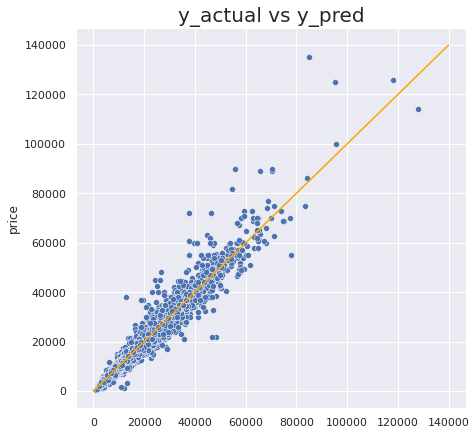

In [ ]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_pred, y=y_test)
plt.title('y_actual vs y_pred', size=20)
point1 = [0, 0]
point2 = [140000, 140000]
x_plot = [point1[0], point2[0]]
y_plot = [point1[1], point2[1]]
plt.plot(x_plot, y_plot, color='orange');

Terdapat residual yang besar dimodel kita, mari kita cari tahu mobil apa itu

In [ ]:
# dataframe actual vs prediction
pred_result = pd.DataFrame(pd.concat([y_test, pd.Series(y_pred, index=y_test.index)], axis=1)).rename(columns={'price':'y_actual',0:'y_pred'})
pred_result['residual'] = abs(pred_result['y_actual'] - pred_result['y_pred'])
pred_result.head()

y_actual        y_pred    residual
12628     13499  14115.147419  616.147419
37730     18990  19084.630175   94.630175
39991     32995  32542.792790  452.207210
8525      15420  16198.561874  778.561874
8279      15995  15120.718161  874.281839

In [ ]:
# residual tertinggi di model
pred_result[pred_result['residual']==pred_result['residual'].max()]

y_actual        y_pred      residual
49177    135000  84888.111722  50111.888278

In [ ]:
# lacak menggunakan indexnya
df_strat[df_strat.index == 49177]
df[(df['manufacturer']=='Audi') & (df['totalMileage']==1000) & (df['engineSize']==5.2)]

manufacturer model  year  ...  totalCO2(Pounds) co2Pounds/Mile   price
3188         Audi    R8  2019  ...        548.780488        0.54878  135000

[1 rows x 12 columns]

In [ ]:
# mean dan median harga mobil Audi R8
print('mean harga mobil Audi R8 : ', df[df['model']==' R8']['price'].mean())
print('median harga mobil Audi R8 : ', df[df['model']==' R8']['price'].median())

mean harga mobil Audi R8 :  97652.21428571429
median harga mobil Audi R8 :  111490.0


Banyak aspek yang dapat mempengaruhi kenapa pemilik mobil memberikan harga sebesar £135000 untuk Audi R8nya, salah satu kemungkinannya bisa jadi karena mobil tersebut sudah dimodifikasi seperti ganti velg, upgrade interior, dll. Hal seperti ini harus ditanyakan langsung ke ownernya, kira-kira hal apa yg membuat si owner menaruh harga yang tinggi?. Setelah kita melakukan riset, ternyata Audi R8 memiliki banyak series, salah satunya Audi R8 Performance Carbon yang dibanderol dikisaran harga £135000an. Tentu hal ini diluar kendali model kita, karena kita tidak bisa memprediksi harga mobil yang sudah dimodifikasi. Ini menjadi salah satu kekurangan model kita.

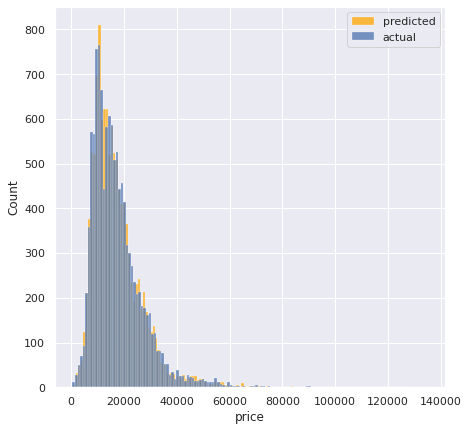

In [ ]:
# actual vs prediction
plt.figure(figsize=(7,7))
sns.histplot(y_pred, label='predicted', color='orange')
sns.histplot(y_test, label='actual')
plt.legend()
plt.show()

Actual dengan predicted terlihat saling membayangi, tanda prediksi harga mobil kita mendekati data aslinya.

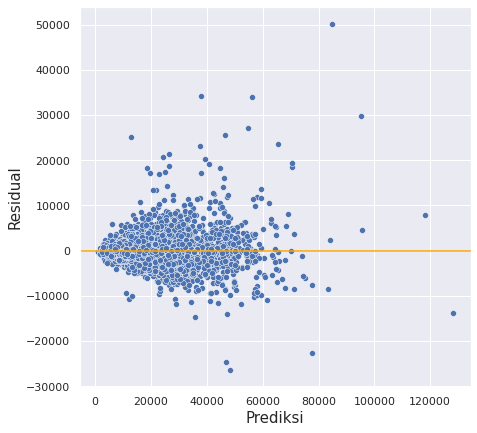

In [ ]:
# residual plot
plt.figure(figsize=(7,7))
plt.xlabel('Prediksi', size=15)
plt.ylabel('Residual', size=15)
residual = y_test - y_pred
sns.scatterplot(x=y_pred, y=residual)
plt.axhline(y=0.5, color='orange', linestyle='-');

Terlihat Homoscedasticity, residual memiliki variance yang homogen (mayoritas residual berkumpul mendekati nol), variance yang homogen menandakan kestabilan model dalam melakukan prediksi, dan hasil seperti inilah yang kita inginkan. Hanya saja untuk prediksi harga mobil diatas £70000, model kita mulai tidak stabil dalam melakukan prediksi karena kurangnya data mobil mewah, untuk prediksi harga mobil dibawah £70000, model kita bisa diandalkan.

# **Problem Statement Solution (ML)**

Client kita tertarik dengan dua mobil yang ada di Exchange and Mart, namun dia tidak tahu apakah harga yang di tawarkan overprice atau underprice. Maka dari itu kita akan memberikan saran harga berdasarkan model ML yang sudah kita buat.

Data berikut adalah data mobil asli yang dijual di Exchange and Mart.

**mobil 1**

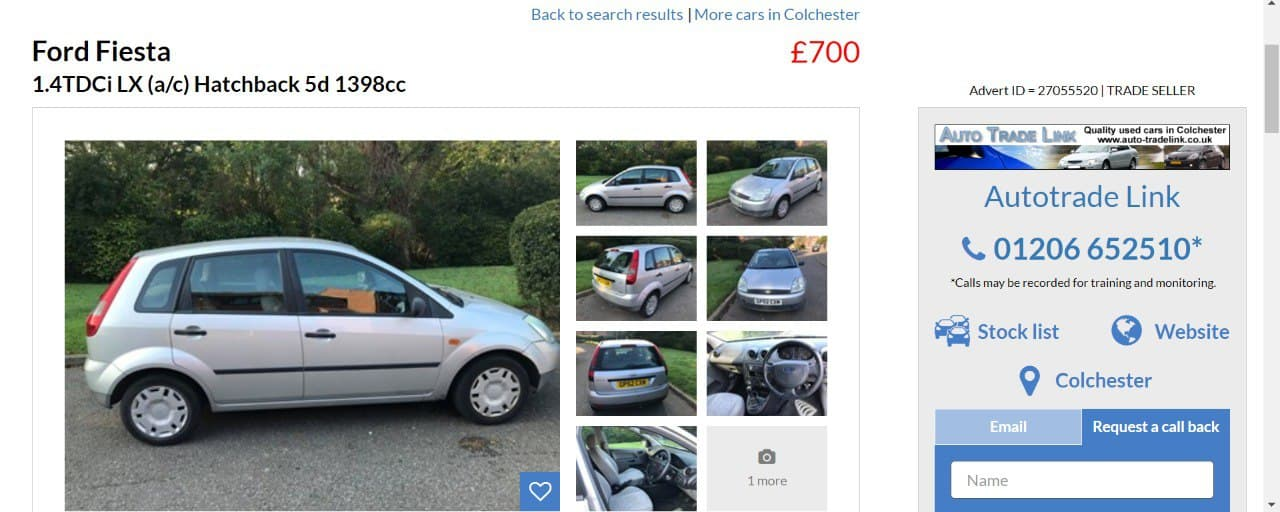

https://www.exchangeandmart.co.uk/ad/27055520

- manufacturer = Ford
- model = Fiesta
- year = 2003
- totalMileage = 113000
- transmission = Manual
- fuelType = Diesel
- fuelConsump(mpg) = 65.7
- tax = £30
- engineSize = 1.4
- co2Pounds/Mile = 0.27
- price = yang ditawarkan £700

**mobil 2**

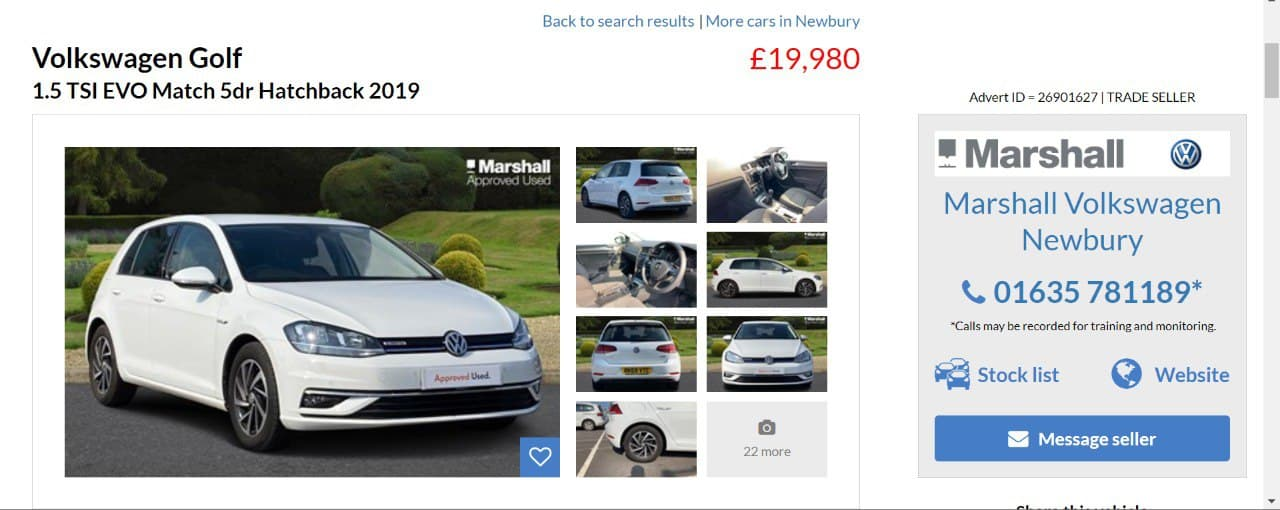

https://www.exchangeandmart.co.uk/ad/26901627

- manufacturer = VW
- model = Golf
- year = 2019
- totalMileage = 6.5
- transmission = Manual
- fuelType = Petrol
- fuelConsump(mpg) = 47.1
- tax = £155
- engineSize = 1.5
- co2Pounds/Mile = 0.38
- price = yang ditawarkan £19980

In [ ]:
# kita buat data diatas dalam bentuk dataframe
data = [['Ford', 2003, 113000, 'Manual', 'Diesel', 65.7, 30, 1.4, 0.27, ' Fiesta'],
        ['VW', 2019, 6.5, 'Manual', 'Petrol', 47.1, 155, 1.5, 0.38, ' Golf']]

X_pred = pd.DataFrame(data,index=[1, 2], columns=X_train.columns)
X_pred

manufacturer  year  totalMileage  ... engineSize co2Pounds/Mile   model2
1         Ford  2003      113000.0  ...        1.4           0.27   Fiesta
2           VW  2019           6.5  ...        1.5           0.38     Golf

[2 rows x 10 columns]

## Prediksi

Untuk menentukan apakah suatu harga mobil itu mahal atau murah, kita akan gunakan cara berikut:
1. Pertama kita cari nilai tengah dari target kita. Berhubung target kita skewed, maka kita gunakan median sebagai nilai tengahnya.
2. Setelah mengetahui median dari terget, selanjutnya kita hitung proporsi RMSE dari median target kita dalam bentuk persen. (2236*100)/17407 = 14.90% = 15%.

Kita mendapati proporsi RMSE terhadap median target kita adalah sebesar 15%, maka interpretasinya: jika suatu harga mobil yang ditawarkan lebih rendah sebesar 15% dari prediksi kita, maka mobil tersebut dianggap murah. Sebaliknya jika suatu harga mobil yang ditawarkan lebih tinggi sebesar 15% dari prediksi kita, maka mobil tersebut kita anggap mahal. Jika masih berada direntang bawah 15% dan rentang atas
15%, maka harga mobil tersebut masih dianggap normal.

In [ ]:
# proporsi RMSE terhadap median target
print((2236*100)/15000,'%')

14.906666666666666 %


median :  15000.0
mean :  17304.982247067375


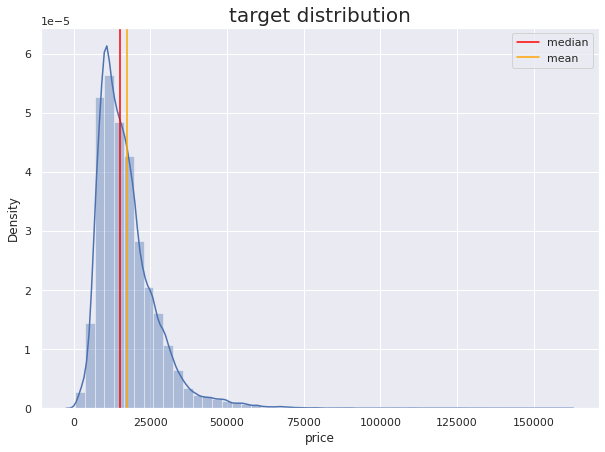

In [ ]:
print('median : ', df['price'].median())
print('mean : ', df['price'].mean())
plt.figure(figsize=(10,7))
sns.distplot(df['price'])
plt.title('target distribution', size=20)
plt.axvline(x=15000, color='red', label='median')
plt.axvline(x=17305, color='orange', label='mean')
plt.legend();

In [ ]:
# function untuk menentukan apakah suatu mobil harganya murah, normal, atau mahal
def prediksi_harga(harga_prediksi, harga_asli):
  batas_bawah = harga_prediksi - ((15/100)* harga_prediksi)
  batas_atas = harga_prediksi + ((15/100)* harga_prediksi)

  if harga_asli < batas_bawah:
    print('mobil ini harganya murah')
  elif harga_asli > batas_atas:
    print('mobil ini harganya mahal')
  else:
    print('mobil ini harganya normal')

**mobil 1**

In [ ]:
hasil_prediksi = loaded_model.predict(X_pred)
harga_asli_m1 = 700
harga_pred_m1 = round(hasil_prediksi[0])
print('Harga asli mobil 1 : ', harga_asli_m1)
print('Harga prediksi mobil 1 : ',harga_pred_m1)
prediksi_harga(harga_pred_m1,harga_asli_m1)

Harga asli mobil 1 :  700
Harga prediksi mobil 1 :  1819
mobil ini harganya murah


**mobil 2**

In [ ]:
hasil_prediksi = loaded_model.predict(X_pred)
harga_asli_m2 = 19980
harga_pred_m2 = round(hasil_prediksi[1])
print('Harga asli mobil 2 : ', harga_asli_m2)
print('Harga prediksi mobil 2 : ',harga_pred_m2)
prediksi_harga(harga_pred_m2,harga_asli_m2)

Harga asli mobil 2 :  19980
Harga prediksi mobil 2 :  19802
mobil ini harganya normal


## Explainable AI

Untuk menjawab 'black-box'nya model kita, kita akan gunakan beberapa library yang bisa digunakan untuk menjelaskan decision proses model yang 'black-box' seperti Shapley Additive Explanations (SHAP), dan juga Local Interpretable Model-agnostic Explanations (LIME).

In [ ]:
# transform X_train
X_train_transformed = loaded_model.named_steps['preprocess'].transform(X_train)

# tracing nama kolom
cat_var_name= list(loaded_model.named_steps['preprocess'].named_transformers_['cat_pipe'].named_steps['nominal_encoder'].get_feature_names())
num_var_name  = ['tax', 'fuelConsump(mpg)', 'engineSize', 'co2Pounds/Mile', 'totalMileage', 'year']
all_var_name = num_var_name + cat_var_name

# convert ke format dataframe
X_train_transformed = pd.DataFrame(X_train_transformed, columns=all_var_name)

In [ ]:
# transform X_test
X_test_transformed = loaded_model.named_steps['preprocess'].transform(X_test)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=all_var_name)

In [ ]:
shap_model = loaded_model.named_steps['model'].fit(X_train_transformed, y_train)
explainer = shap.TreeExplainer(shap_model)
sample = X_test_transformed.sample(1000,random_state=42)
shap_values = explainer.shap_values(sample)

### Feature Importance

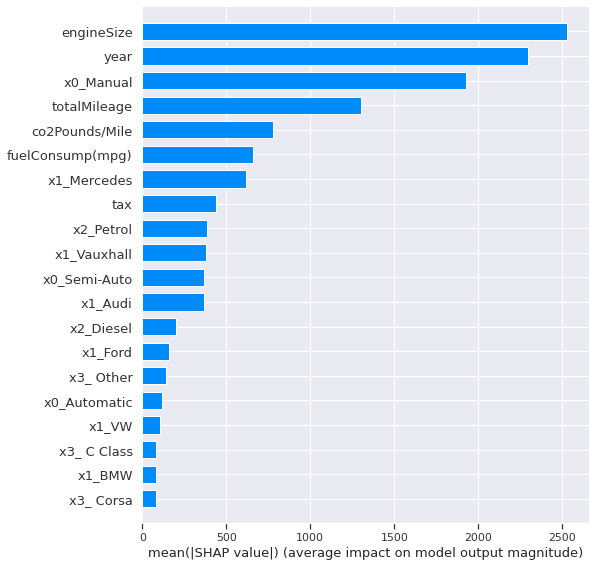

In [ ]:
shap.summary_plot(shap_values, sample, plot_type="bar")

Berdasarkan visualisasi Feature Importance diatas, terlihat  bahwa engine size, year, dan transmisi manual memiliki pengaruh terbesar terhadap harga mobil. Namun kita tidak tahu kearah mana pengaruhnya, apakah semakin besar engine size akan menaikan harga? atau malah menurunkan harga? Untuk menjawabnya kita akan gunakan Summary plot dari SHAP dibawah ini.

### Global Interpretation

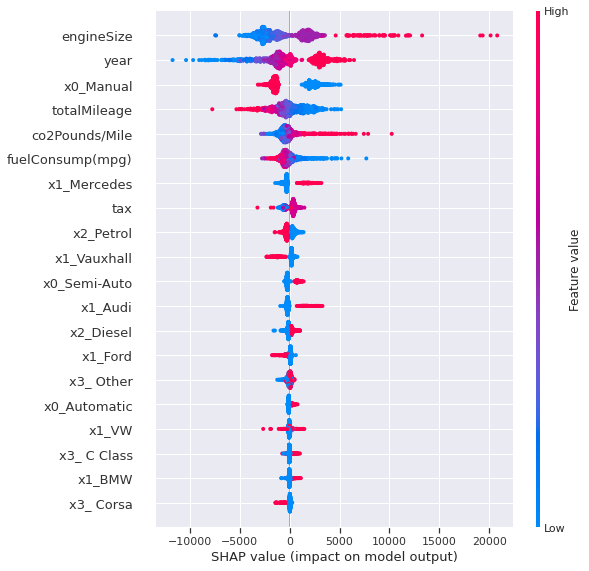

In [ ]:
shap.summary_plot(shap_values, sample)

Dengan summary plot SHAP ini kita bisa mengetahui arah pengaruh suatu fitur, dari sini terjawab pertanyaan kita sebelumnya ternyata semakin besar engine size maka harga mobil pun menjadi semakin mahal. Begitu juga dengan year, semakin muda tahunnya semakin tinggi juga harganya. Yang mengejutkan, ternyata mobil dengan transmisi manual malah memberikan efek penurunan harga.

### Local Interpretation

In [ ]:
model_lime = loaded_model.named_steps['model'].fit(X_train_transformed,y_train)

# lime
explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(X_train_transformed),
                                              mode='regression',
                                              feature_names = X_train_transformed.columns,
                                              categorical_features= X_train_transformed.iloc[:,6:])

In [ ]:
X_pred_transformed = loaded_model.named_steps['preprocess'].transform(X_pred)
X_pred_transformed = pd.DataFrame(X_pred_transformed, columns=all_var_name)

**mobil 1**

In [ ]:
exp = explainer.explain_instance(data_row= X_pred_transformed.iloc[0],
                                 predict_fn= model_lime.predict)
exp.show_in_notebook(show_table = True)

In [ ]:
exp.as_list()

[('year <= 2016.00', -5168.899922446285),
 ('totalMileage > 31125.00', -2642.3237938025245),
 ('0.00 < x0_Manual <= 1.00', -2575.2723673384025),
 ('1.30 < engineSize <= 1.60', -2422.778272261468),
 ('x1_Mercedes <= 0.00', -2111.5975917628407),
 ('x1_Audi <= 0.00', -1890.8161676352936),
 ('x1_Vauxhall <= 0.00', 1518.7349790158387),
 ('co2Pounds/Mile <= 0.30', -1384.8418974215735),
 ('fuelConsump(mpg) > 60.10', -1080.0628844284306),
 ('x3_ Corsa <= 0.00', 904.3750117473855)]

Pengaruh terbesar yang membuat harga mobil 1 turun adalah tahunnya yang sudah tua, total mileage yang sangat besar, dan transmisinya yang berjenis manual. Pengaruh manufacturer lain seperti Mercedes juga memberikan pengaruh terhadap penurunan harga mobil. 

**mobil 2**

In [ ]:
exp = explainer.explain_instance(data_row= X_pred_transformed.iloc[1],
                                 predict_fn= model_lime.predict)
exp.show_in_notebook(show_table = True)

In [ ]:
exp.as_list()

[('2017.00 < year <= 2019.00', 3708.6122925686063),
 ('0.00 < x1_Manual <= 1.00', -2620.1135721184673),
 ('totalMileage <= 6989.00', 2565.6765702834305),
 ('1.30 < engineSize <= 1.60', -2249.7812268765692),
 ('x0_Mercedes <= 0.00', -2074.2037407834077),
 ('x0_Audi <= 0.00', -2001.7991120602032),
 ('x0_Vauxhall <= 0.00', 1685.53732355542),
 ('x0_Hyundai <= 0.00', 801.5801473618122),
 ('x2_Hybrid <= 0.00', -654.789664990259),
 ('x0_Ford <= 0.00', 550.9784743583386)]

Sebaliknya, fitur yang membuat mobil 2 harganya tinggi adalah tahunnya yang masih muda, dan total mileagenya yang sangat sedikit, sayangnya transmisi manual juga membuat harga mobil ini turun.

In [ ]:
df.head()

manufacturer model  year  ...  totalCO2(Pounds) co2Pounds/Mile  price
0         Audi    A1  2017  ...       5112.454874       0.324910  12500
1         Audi    A6  2016  ...      10150.373832       0.280374  16500
2         Audi    A1  2016  ...       9729.747292       0.324910  11000
3         Audi    A4  2017  ...       6941.099554       0.267459  16800
4         Audi    A3  2019  ...        725.080645       0.362903  17300

[5 rows x 12 columns]

# Problem Statement Solution (Analytic)

Depresiasi mobil adalah selisih harga mobil saat anda membeli dan menjualnya. Terdapat banyak hal yang bisa mempengaruhi tingkat depresiasi suatu mobil, salah satunya adalah total mileage yang digunakan, sudah berapa kali mobil tersebut berpindah tangan, dari brand apa mobil tersebut berasal, dan lain-lain. 

Kita hanya akan mempertimbangkan faktor usia mobil untuk menghitung depresiasinya karena usia mobil merupakan variabel yang paling berpengaruh terhadap penurunan suatu harga mobil.

In [ ]:
# copy dari data asli agar tidak saling tumpang tindih
df_dep = df.copy()

# tambahkan fitur 'yearOfUse'
df_dep['yearOfUse'] = 2020 - df_dep['year']

list_yearOfUse = []
manufacturer_ = []

df_dep_result = pd.DataFrame([manufacturer_, list_yearOfUse])
for i in df_dep['manufacturer'].unique():
  y = df_dep[df_dep['manufacturer']==i]['price']
  X = df_dep[df_dep['manufacturer']==i]['yearOfUse']
  X = sm.add_constant(X)  

  ols = sm.OLS(y,X)
  result = ols.fit()
  
  list_yearOfUse.append(result.params['yearOfUse'])
  manufacturer_.append(i)

In [ ]:
df_dep_result = pd.concat([pd.Series(manufacturer_),pd.Series(list_yearOfUse)],axis=1)
df_dep_result = df_dep_result.rename(columns={0:'manufacturer',1:'Based on yearOfUse'})
df_dep_result 

manufacturer  Based on yearOfUse
0         Audi        -3102.909188
1          BMW        -3017.555843
2     Mercedes        -2823.715763
3         Ford        -1521.896698
4      Hyundai        -1778.962157
5        Skoda        -2180.017139
6       Toyota        -1165.171438
7     Vauxhall        -1197.565035
8           VW        -2288.310760

Sebagai pembeli, setelah anda menemukan mobil incaran anda, anda ingin memastikan bahwa kendaraan yang anda beli dapat mempertahankan valuenya untuk waktu yang lama. Begitu juga dengan client kita, apabila mobilnya tidak bisa terjual pada tahun ini (2020) setidaknya dia sudah punya bayangan akan mengalami depresiasi sebesar apa ditahun-tahun berikutnya.

Berikut adalah ringkasan tabel diatas:

Manufacturer yang mengalami depresiasi terbesar berdasarkan yearOfUse:
- Audi
- VW
- Skoda

Manufacturer yang mengalami depresiasi terkecil berdasarkan yearOfUse:
- Vauxhall
- Toyota
- Ford

# **Conclusion**

DI notebook ini kita mencoba memprediksi harga mobil bekas, yang bertujuan agar pelaku bisnis jual beli mobil bekas bisa meminimalkan efek overpricing maupun underpricing ketika melakukan jual beli. Selain itu kita juga mencari manucaturer mana yang mengalami depresiasi value terbesar dan terkecil.



**Conclusion and Recommendation for ML Problem**

Untuk memprediksi harga mobil, kita membuat model ML menggunakan algoritma Random Forest. Berhubung pengguna model ML ini nantinya adalah orang yang awam dibidang data, maka untuk menjawab ke 'black-box'an model, kita berikan visualisasi berupa feature importance, global summary, dan local summary yang bisa menjelaskan decision process model ML kita.

Berdasarkan visualisasi feature importance yang telah kita buat, empat faktor berikut adalah faktor yang paling memiliki pengaruh dalam penentuan harga mobil, yaitu: engine size, year, jenis transmisi, dan total mile age.

- Semakin besar engine size harganya semakin mahal. Faktor ini memiliki andil yang cukup besar dalam penentuan mahal atau tidaknya harga mobil.

- Semakin tua year, harganya semakin murah. Year adalah faktor utama yang paling mempengaruhi penurunan harga mobil.

- Jenis transmisi manual memiliki efek menurunkan harga mobil, namun impactnya kecil tidak sebesar year. Sebaliknya, jenis transmisi Semi-Auto lebih bisa meningkatkan harga jual, namun impactnya juga kecil.

- Semakin besar total mileage, harganya semakin murah.

Kita sarankan sebelum membeli mobil alangkah baiknya untuk mempertimbangkan keempat faktor diatas terlebih dahulu. Karena empat faktor diatas adalah faktor yang paling mempengaruhi harga. 

Untuk menentukan apakah suatu harga mobil itu mahal atau murah, kita akan gunakan cara berikut:

1. Pertama kita cari nilai tengah dari target kita. Berhubung target kita skewed, maka kita gunakan median sebagai nilai tengahnya.
2. Setelah mengetahui median dari terget, selanjutnya kita hitung proporsi RMSE dari median target kita dalam bentuk persen. (2236*100)/17407 = 14.90% = 15%.

Kita mendapati proporsi RMSE terhadap median target kita adalah sebesar 15%, maka interpretasinya: jika suatu harga mobil yang ditawarkan lebih rendah sebesar 15% dari prediksi kita, maka mobil tersebut dianggap murah. Sebaliknya jika suatu harga mobil yang ditawarkan lebih tinggi sebesar 15% dari prediksi kita, maka mobil tersebut kita anggap mahal. Jika masih berada direntang bawah 15% dan rentang atas
15%, maka harga mobil tersebut masih dianggap normal.

Model kita memiliki kelemahan, yaitu tidak bisa extrapolasi diluar rentang price yang sudah di pelajari, dan juga model kurang bisa dipercaya jika harus memprediksi harga mobil diatas £70000, karena memang tidak banyak mobil yang harganya diatas £70000. Selain itu model kita tidak bisa memprediksi harga mobil yang sudah dimodifikasi, kita melakukan prediksi dengan asumsi bahwa mobil yang ada di Exchange and Mart memiliki kondisi yang standard.

**Conclusion and Recommendation for Analytic Problem**

Kesimpulannya, jika ingin melakukan jual beli mobil di Exchange and Mart, mobil dari manufacturer Vauxhall, Toyota, dan Ford bisa jadi pertimbangan untuk dibeli karena nilai depresiasinya yang paling kecil. Tentunya perhitungan depresiasi ini hanya hitungan kasarnya saja, bisa dijadikan acuan, namun tidak untuk dijadikan ukuran pasti, karena memang ada banyak sekali faktor yang membuat value mobil itu turun.